<a href="https://colab.research.google.com/github/IgorOberon/NLA-project-small-matrix/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_NLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import fractional_matrix_power
from scipy.linalg import sqrtm
import time

In [26]:
# все основные функции

def matrix_sqrt_analytic(A, signum = 1):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    p = (det_A)**0.5

    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    result = (signum*I*p + A)/((trace_A + signum*2*p)**0.5)
    return result

def power_matrix_2_2(A, n):
  '''
  Вычисляет степень матрицы для всех возможных случаев
  '''
  trA = np.trace(A)
  detA = np.linalg.det(A)
  if trA == 0:
      if n % 2 == 0:
        k = n // 2
        if k % 2 == 0 or detA < 0:
          signum = 1
        else:
          signum = -1
        return signum*(abs(detA)**k)*np.array([
        [1, 0],
        [0, 1]
    ])
      else:
        k = (n - 1) // 2
        if k % 2 == 0 or detA < 0:
          signum = 1
        else:
          signum = -1
        return signum*(abs(detA)**k)*A


  dA = trA**2 - 4*detA
  if dA > 0:  # гиперболические матрицы
    if detA < 0:  # пространственно-подобные матрицы
      if n%2 == 0:
        return power_hyperbolic_matrix_even(A, n, trA, detA, dA)
      else:
        return power_hyperbolic_matrix_odd(A, n, trA, detA, dA)
    if detA > 0: # времениподобные матрицы
       return power_hyperbolic_matrix_even(A, n, trA, detA, dA)
    if detA == 0: # светоподобные матрицы
      return (trA**(n-1))*A

  elif dA < 0: # эллиптические матрицы, они все времениподобные
    return power_elliptic_matrix(A, n, trA, detA, dA)

  else: # параболические матрицы, у них одинаковые собственные числа
    if detA > 0: # пространственно-подобные (времениподобных не может быть)
      return power_parabolic_matrix(A, n, trA, detA, dA)
    else:  # светоподобная параболическая матрица одна - нулевая
      return np.array([
        [0, 0],
        [0, 0]
    ])

  return -1




def power_hyperbolic_matrix_even(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень гиперболической матрицы 2x2 (det(A) < 0, n - четное).

    """
    p = np.sqrt(np.abs(detA))  # Так как detA < 0, используем abs
    a, b, c, d = A.flatten()
    pA = dA**0.5
    try:
      theta = math.log(abs((trA + pA) / (2 * p)))
    except:
      print(A, 'математическая ошибка', 'detA = ', detA)
    thn = n*theta
    cosh_ntheta = np.cosh(thn)
    sinh_ntheta = np.sinh(thn)
    spA = sinh_ntheta/pA
    adspA = (a-d)*spA

    a11 = cosh_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = cosh_ntheta - adspA
    signum = 1
    if n % 2 != 0:
      if trA < 0:
        signum = -1

    result = signum*(abs(detA)**(n/2))*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_hyperbolic_matrix_odd(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень гиперболической матрицы 2x2 (det(A) < 0, n - нечетное).

    """

    p = np.sqrt(np.abs(detA))  # Так как detA < 0, используем abs

    a, b, c, d = A.flatten()


    pA = dA**0.5
    try:
      theta = math.log(abs((trA + pA) / (2 * p)))
    except:
      print(A, 'математическая ошибка', 'detA = ', detA)
    thn = n*theta
    cosh_ntheta = np.cosh(thn)
    sinh_ntheta = np.sinh(thn)

    spA = cosh_ntheta/pA
    adspA = (a-d)*spA

    a11 = sinh_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = sinh_ntheta - adspA

    if trA > 0:
      signum = 1
    else:
      signum = -1

    signum = 1

    result = signum*(abs(detA)**(n/2))*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_elliptic_matrix(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень эллиптической матрицы 2x2 (det(A) > 0).

    Args:
        A: Матрица 2x2 (NumPy array).
        n: Целое неотрицательное число.

    Returns:
        n-ая степень матрицы A (NumPy array).
        Возвращает None, если det(A) <= 0.
    """
    a, b, c, d = A.flatten()
    pA = (abs(dA))**0.5
    theta = np.arctan2(pA, trA)
    p = np.sqrt(np.abs(detA))  # Так как detA может быть < 0, используем abs

    cos_ntheta = np.cos(n * theta)
    sin_ntheta = np.sin(n * theta)
    spA = sin_ntheta/pA
    adspA = (a-d)*spA

    a11 = cos_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = cos_ntheta - adspA

    result = (p**n)*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_parabolic_matrix(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень параболической матрицы 2x2 (det(A) = 0).

    Args:
        A: Матрица 2x2 (NumPy array).
        n: Целое неотрицательное число.

    Returns:
        n-ая степень матрицы A (NumPy array).
        Возвращает None, если det(A) != 0.
    """

    a, b, c, d = A.flatten()
    t = abs(trA)
    theta = (a-d)/t

    if trA > 0:
      signum = 1
    else:
      signum = -1

    q = signum*n*theta
    a11 = 1 + q
    a12 = (b*n * 2)/(trA)
    a21 = (c*n * 2)/(trA)
    a22 = 1 - q

    result = ((0.5*trA)**n)*np.array([
        [a11, a12],
        [a21, a22]
    ])
    return result

'''
A = np.array([
    [-10, -5],
    [  6,  3]
] )

result = power_matrix_2_2(A, 1)
print(result)

'''

def test_matrix_power():
    num_tests = 10  # Количество тестов
    max_power = 5   # Максимальная степень для тестирования
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)

        for n in range(1, max_power + 1):
            result = power_matrix_2_2(A, n)
            expected_result = np.linalg.matrix_power(A, n)
            error = np.linalg.norm(result - expected_result, ord=2)
            flag = (error > 0.001)
            # Вывод результатов
            if flag:
              print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по второй норме: {error}\n")
              if error > 0.1:
                print(det_A)
    return -1


def matrix_power_analytic(A, n):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r = (u*u - det_A)**0.5 ;

    q1, q2 = (u + r)**n, (u - r)**n
    p1 = 0.5*(q1 + q2)
    p2 = 0
    if abs(r) < abs(u):
      t = r/u
      if abs(t) < 10**(-14):
        p2 = n*(u**(n-1))
      else:
        p2 = (u**n)*((1+t)**n - (1-t)**n)*0.5/r
    elif abs(r) >= abs(u):
      t = u/r
      p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5

    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    # Применяем формулу
    result = p1*I + p2*(A - u*I)


    return result

def test_matrix_power2():
    num_tests = 10 # Количество тестов
    max_power = 5   # Максимальная степень для тестирования
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)

        for n in range(1, max_power + 1):
            result = matrix_power_analytic(A, n)
            expected_result = np.linalg.matrix_power(A, n)
            error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
            flag = (error > 10**(-15))
            # Вывод результатов
            if flag:
              print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
              if error > 0.1:
                print(det_A)
    return -1

def pade_approximation(A, k, m):
    n = A.shape[0]
    P = np.zeros((n, n), dtype=complex)
    Q = np.zeros((n, n), dtype=complex)
    H = np.eye(n, dtype=complex)
    signum = 1
    for j in range(k + 1):

        P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
        Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H
        H = H @ A
        signum = -signum

    '''  В нашем случае мы будем использовать k = m, так что проще отдельный цикл не писать
    for j in range(m + 1):
        Q += (np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * np.linalg.matrix_power(-A, j)
    '''
    return np.linalg.solve(Q, P)


def matrix_exp_scaled_squared(A, s, k, m):

    scaled_A = A / (2**s)
    R = pade_approximation(scaled_A, k, m)

    for _ in range(s):
        R = np.dot(R, R)

    return R



def true_matrix_exponential(A):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    eigvals, P = np.linalg.eig(A); D = np.diag(np.exp(eigvals))
    expA = P @ D @ np.linalg.inv(P)
    return expA

def lim_matrix_exponential(A, N):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    s = 2**N; I = np.eye(A.shape[0], dtype=A.dtype); expA = I + A / s

    for k in range(N):
        expA = matrix_squaring(expA)
    return expA

def matrix_squaring(A):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    Asqr = np.array([[A[0][0]**2 + A[0][1]*A[1][0], A[0][1]*(A[0][0] + A[1][1])],
                     [A[1][0]*(A[0][0] + A[1][1]), A[1][1]**2 + A[0][1]*A[1][0]]])
    return Asqr

def matrix_exponential_taylor_naivn(A, iterations):
    n = A.shape[0]
    result = np.eye(n, dtype=complex)
    term = np.eye(n, dtype=complex)
    for i in range(1, iterations + 1):
        term = np.dot(term, A) / i
        result += term
    return result

def matrix_exp_scaled_squared_for_taylor(A, s, iterations):

    scaled_A = A / (2**s)
    R = matrix_exponential_taylor_naivn(scaled_A, iterations)

    for _ in range(s):
        R = np.dot(R, R)

    return R


def matrix_exponent_taylor_gamilton(A, num_iterations=15):
    """Вычисляет экспоненту матрицы 2x2 с помощью ряда Тейлора и теоремы Гамильтона-Кэли."""
    I = np.eye(2)
    n = A.shape[0]

    # Характеристический полином: p(λ) = λ^2 - tr(A)λ + det(A)
    trace_A = np.trace(A)
    det_A = np.linalg.det(A)

    # Теорема Гамильтона-Кэли: A^2 - tr(A)A + det(A)I = 0
    # A^2 = tr(A)A - det(A)I

    result = I + A
    A_power = A.copy()
    A_prev = I

    for k in range(2, num_iterations):
        A_power, A_prev = trace_A * A_power - det_A * A_prev, A_power  # Используем предыдущую степень
        result += (1 / math.factorial(k)) * A_power

    return result

def matrix_exp_scaled_squared_for_taylor_gamilton(A, s, iterations = 15):

    scaled_A = A / (2**s)
    R = matrix_exponential_taylor_naivn(scaled_A, iterations)

    for _ in range(s):
        R = np.dot(R, R)

    return R


def matrix_log_analytic(A):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r2 = (u*u - det_A) ;
    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    if abs(r2) > 10**(-14):
      r = r2**0.5
      s = np.log((u+r)/(u-r))
      p1 = np.log(det_A)
      p2 = s/r
      result = (p1*I + p2*(A - u*I))*0.5
      return result

    result = 0.5*(I*np.log(det_A) + (2/u)*(A - u*I))
    return result


def test_matrix_logs():
    num_tests = 10 # Количество тестов
    flag = False
    mxerror = -1
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        B = expm(A)
        det_A = np.linalg.det(A)
        result = matrix_log_analytic(B)
        expected_result = logm(B)
        error = np.linalg.norm(A - result, 'fro')/np.linalg.norm(A, 'fro')
        flag = (error > 10**(-9))
        mxerror = max(mxerror, error)

        # Вывод результатов
        if flag:
          print(f"Матрица A:\n{A}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
          if error > 0.1:
            print(det_A)
    print('максимальная относительная ошибка была равна ', mxerror)
    return -1

def matrix_exp_analytic(A, q = 1):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r2 = (u*u - det_A) ;
    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    if r2 > 10**(-15):
      r = r2**0.5
      p1 = np.cosh(r*q)
      p2 = np.sinh(r*q)/r
      result = (p1*I + p2*(A - u*I))*math.exp(u*q)
      return result

    if r2 < -10**(-15):
      r = abs(r2)**0.5
      p1 = np.cos(r*q)
      p2 = np.sin(r*q)/r
      result = (p1*I + p2*(A - u*I))*math.exp(u*q)
      return result

    result = math.exp(u*q)*(I + q*(A - u*I))
    return result


def test_matrix_exps():
    num_tests = 100 # Количество тестов
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)
        result = matrix_exp_analytic(A)
        expected_result = expm(A)
        error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
        flag = (error > 10**(-14))
        # Вывод результатов
        if flag:
          print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
          if error > 0.1:
            print(det_A)
    return -1


#Вычисление матричных функций от матриц малого размера

## Обзор методов вычисления матриц.

### Аналитические методы вычисления функций от матриц $2 \times 2$.



#### **Подход первый (мой) - алгебры Клиффорда.**

Используем матричное представление алгебры Клиффорда $Cl(2,0,0)$

$$
\begin{aligned}
& \left(\begin{array}{ll}
a & b \\
c & d
\end{array}\right)=u \cdot \mathbf{I}+v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}} \\
& \mathbf{e}_{\mathbf{1}}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right), \quad \mathbf{e}_{\mathbf{2}}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \mathbf{e}_{\mathbf{12}}=\left(\begin{array}{cc}
0 & 1 \\
-1 & 0
\end{array}\right)
\end{aligned}
$$

Векторные элементы, включая бивектор, антикоммутируют между собой: $\left\{\mathbf{e}_{\mathbf{i}}, \mathbf{e}_{\mathbf{j}}\right\} = 0$

Это позволяет легко вычислить степень векторной части:

$$
\left(v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}}\right)^{2 n}=\left(v^2+w^2-t^2\right)^n = r^{2n}
$$

где

$$
 r=\sqrt{\omega^2+v^2-t^2};\quad  u=\frac{a+d}{2}, \quad v=\frac{a-d}{2}, \quad w=\frac{b+c}{2}, \quad t=\frac{b-c}{2}
$$



Посчитаем, например, экспоненту

$$
\exp (A \cdot q)=\mathrm{I}+q \cdot A+\frac{q^2}{2} A^2+\frac{q^3}{3!} A^3+\ldots = e^{u \cdot q} \cdot \exp \left(q \cdot\left(v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}}\right)\right)
$$

$$
\exp \left(q \cdot\left(v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}}\right)\right)=\mathbf{I}+q \cdot\left(v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}}\right)+\frac{q^2}{2} \cdot r^2+\frac{q^3}{6} r^2 \cdot\left(v \cdot \mathbf{e}_1+w \cdot \mathbf{e}_2+t \cdot \mathbf{e}_{12}\right)+\ldots
$$

$$
e^{A \cdot q}=e^{u \cdot q} \cdot\left(\cosh (r \cdot q) \cdot \mathbf{I}+\frac{\sinh (r \cdot q)}{r}\left(v \cdot \mathbf{e}_{\mathbf{1}}+w \cdot \mathbf{e}_{\mathbf{2}}+t \cdot \mathbf{e}_{\mathbf{1 2}}\right)\right)
$$

Полученную формулу можно назвать обобщенной формулой Муавра, потому что в случае $v = w  = 0$ она переходит в формулу Муавра с матричным представлением комплексных чисел (вещественная часть равна $u$, мнимая часть равна $t$).

Теперь найдем степенную функцию.

$$
\begin{aligned}
& \left(u I+v e_1+w e_2+t e_{12}\right)^n=u^n \cdot\left(I+\left(\frac{v e_1+w e_2+t e_{12}}{u}\right)\right)^n=A^n \\
& (1+\mathrm{x})^n=1+n x+\mathrm{C}_n^2 x^2+\ldots \\
& (1-\mathrm{x})^n=1-n x+\mathrm{C}_n^2 x^2-\ldots \\
& 1+\mathrm{C}_n^2 x^2+\mathrm{C}_n^4 x^4+\ldots=\frac{(1+x)^n+(1-x)^n}{2}
\end{aligned}
$$

В итоге получаем формулу, которая работает для произвольных $n$ (даже комплексных - можно легко проверить)

$$
\mathrm{A}^n=\frac{\left(1+\frac{r}{u}\right)^n+\left(1-\frac{r}{u}\right)^n}{2} u^n \cdot I+u^n \cdot\frac{\left(1+\frac{r}{u}\right)^n-\left(1-\frac{r}{u}\right)^n}{2 r}\left(v e_1+w e_2+t e_{12}\right)
$$



Можем эту формулу переписать чуть проще

$$
\alpha_n=(r+u)^n \quad \beta_n=(u-r)^n ; A^n=\frac{\alpha_n+\beta_n}{2} I+\frac{\alpha_n-\beta_n}{2 r}\left(v e_1+w e_2+t e_{12}\right)
$$

Частный случай - обратная матрица
$$
A^{-1}=\frac{u I-\left(v e_1+w e_2+t e_{12}\right)}{u^2-r^2} ; \quad \left(\begin{array}{ll}
u+v & w+t \\
w-t & u-v
\end{array}\right)^{-1} = \frac{1}{\Delta}\left(\begin{array}{cc}
u-v & -w-t \\
t-w & u+v
\end{array}\right)
$$

Аналогично можно вывести логарифм

$$
\ln (A)=\frac{1}{2}\left(\ln (\operatorname{det} A) \cdot I+\frac{s}{r}\left(\begin{array}{cc}
v & w+t \\
w-t & -v
\end{array}\right)\right) ; \quad s=\ln \left(\frac{u+r}{u-r}\right)
$$



Отдельно можно отметить смысл параметра t как параметра генератора вращения, а параметра w - как параметра генератора гиперболического поворота

$$
e^{\left(\begin{array}{ll}
0 & -1 \\
1 & 0
\end{array}\right) \cdot (-t)}=- \left(\begin{array}{cc}
\cos t & -\sin t \\
\sin t & \cos t
\end{array}\right); \quad e^{\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right) w}=\left(\begin{array}{cc}
\cosh (w) & \sinh (w) \\
\sinh (w) & \cosh (w)
\end{array}\right)
$$

Параметры v и w задают вектор, который является генератором параболического поворота. Направление этого вектора определяет положение осей гиперболы.

####**Подход второй - через собственные числа и характеристическое уравнение.**

Присутствует в некоторых научных статьях.

Лемма 1:

Пусть $A=\left(\begin{array}{ll}a & b \\ 0 & d\end{array}\right) \in C^{2 \times 2}$.

i) Если $a=d$ то $e^A=e^a\left(\begin{array}{ll}1 & b \\ 0 & 1\end{array}\right)$.

ii) Если $a \neq d$ то $e^A=\left(\begin{array}{cc}e^a & b\left(e^a-e^d\right) /(a-d) \\ 0 & e^d\end{array}\right)$.

Лемма 2:

Пусть $\lambda$ и $\mu$ обозначают собственные значения матрицы $A \in$ $\boldsymbol{C}^{2 \times 2}$.

i) Если $\mu=\lambda$ то

$$
e^A=e^\lambda[(1-\lambda) I+A] .
$$

ii) Если $\mu \neq \lambda$ то

$$
e^A=\frac{\mu e^\lambda-\lambda e^\mu}{\mu-\lambda} I+\frac{e^\mu-e^\lambda}{\mu-\lambda} A .
$$

Лемма 3:

Пусть $A=\left(\begin{array}{ll}a & b \\ c & d\end{array}\right) \in C^{2 \times 2}$.

i) Если $(a-d)^2+4 b c=0$ то

$$
e^A=e^{(a+d) / 2}\left(\begin{array}{cc}
1+\frac{a-d}{2} & b \\
c & 1-\frac{a-d}{2}
\end{array}\right)
$$

ii) Если $(a-d)^2+4 b c \neq 0$ то

$$
e^A=e^{(a+d) / 2}\left(\begin{array}{cc}
\cosh (\Delta)+\frac{a-d}{2} \frac{\sinh (\Delta)}{\Delta} & b \frac{\sinh (\Delta)}{\Delta} \\
c \frac{\sinh (\Delta)}{\Delta} & \cosh (\Delta)-\frac{a-d}{2} \frac{\sinh (\Delta)}{\Delta}
\end{array}\right)
$$

где

$$
\Delta=\frac{1}{2} \sqrt{(a-d)^2+4 b c} .
$$

Аналогично можно вывести через теорему Гамильтона-Кэли для произвольных аналитических функций.



#### **Подход третий - через интерполяционные формулы для матриц.**

Присутствует в Википедии и некоторых учебниках.

Для произвольной функции $f(A)$ от $2 \times 2$ матрицы A можно вывести с помощью интерполяционной формулы Сильвестра

$$
f(A)=\frac{f\left(\lambda_{+}\right)+f\left(\lambda_{-}\right)}{2} I+\frac{A-\left(\frac{\operatorname{tr}(A)}{2}\right) I}{\sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|}} \frac{f\left(\lambda_{+}\right)-f\left(\lambda_{-}\right)}{2},
$$

где $\lambda_{\text {上 }}$ собственные числа матрицы, $|A-\lambda I|=0$, и они могут быть выражены как

$$
\lambda_{ \pm}=\frac{\operatorname{tr}(A)}{2} \pm \sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|} .
$$


В вырожденном случае можно записать так, где $f^{\prime}$ производная функции $f$.

$$
f(A)=f\left(\frac{\operatorname{tr}(A)}{2}\right) I+\operatorname{adj}\left(\frac{\operatorname{tr}(A)}{2} I-A\right) f^{\prime}\left(\frac{\operatorname{tr}(A)}{2}\right) .
$$

В теории матриц, формула Сильвества (матричная теорема Сильвестра) или как её называют интерполяция Лагранжа-Сильвестра, позволяет выразить аналитическую функцию матрицу через многочлен от матрицы, в терминах собственных чисел и собственных векторов этой матрицы.


$$
f(A)=\sum_{i=1}^k f\left(\lambda_i\right) A_i
$$

где $\lambda_i$ собственные числа $A$, и матрица

$$
A_i \equiv \prod_{\substack{j=1 \\ j \neq i}}^k \frac{1}{\lambda_i-\lambda_j}\left(A-\lambda_j I\right)
$$

являются соответствующими ковариантами Фробениуса, которые являются (проекционными) матричными полиномами Лагранжа.



#### **Подход четвертый. Использовать Жорданову форму.**



$$
(\lambda-a) \cdot(\lambda-d)-b \cdot c=0 ; \lambda^2-\lambda(a+d)+a \cdot d-b \cdot c=0 ; D=(a+d)^2-4 \cdot(a \cdot d-b \cdot c) = (a-d)^2+4 \cdot b \cdot c
$$

$$
\lambda_{1,2}=\frac{a+d}{2} \pm \frac{\sqrt{D}}{2} ; \left(\begin{array}{cc}
\frac{-d+a}{2}-\frac{\sqrt{D}}{2} & b \\
c & \frac{d-a}{2}-\frac{\sqrt{D}}{2}
\end{array}\right)\binom{x_1}{y_1}=\binom{0}{0}
$$

$$
\begin{aligned}
& \quad h_1^{\top}=(2 b, d+\sqrt{D}-a) \\
& h_2^{\top}=(2 b ; d-\sqrt{D}-a) \quad H=\left(\begin{array}{cc}
2 b & 2 b \\
d-a+\sqrt{D} & d-a-\sqrt{D}
\end{array}\right) \\
& J=H A H^{-1}
\end{aligned}
$$

Кроме того, случай равенства нулю дискриминанта требует отдельного исследования.

В данном случае проще работать с выделением бесследовой части матрицы.

$$
A=\sigma I+M, \quad \sigma=\operatorname{trace}(T) / n
$$

здесь $M$ - бесследовая часть матрицы, $\sigma$ - среднее арифметическое собственных чисел матрицы.

Используя ряд Тейлора, можно записать

$$
f(\sigma+z)=\sum_{k=0}^{\infty} \frac{f^{(k)}(\sigma)}{k!} z^k
$$

Так как диагональная коммутирует с любой матрицей, то это значит, что

$$
f(A)=\sum_{k=0}^{\infty} \frac{f^{(k)}(\sigma)}{k!} M^k
$$

#### **Подход пятый - разложение Шура.**

В случае матриц большего размера основанные на нем численные методы вычислений функций от матриц считаются самыми эффективными (алгоритм Шура-Парлетта используется во многих библиотеках как основной). Но в случае матриц 2 на 2 он позволяет также вывести и аналитическую формулу.

$$
\begin{aligned}
& \left(\begin{array}{cc}
\cos \varphi & \sin \varphi \\
-\sin \varphi & \cos \varphi
\end{array}\right)\left(\begin{array}{ll}
a & b \\
c & d
\end{array}\right) \cdot\left(\begin{array}{cc}
\cos \varphi & -\sin \varphi \\
\sin \varphi & \cos \varphi
\end{array}\right)=\left(\begin{array}{ll}
x & y \\
0 & z
\end{array}\right) \\
& \left(\begin{array}{ll}
a & b \\
c & d
\end{array}\right)^n=\left(\begin{array}{cc}
\cos \varphi & -\sin \varphi \\
\sin \varphi & \cos \varphi
\end{array}\right) \cdot\left(\begin{array}{ll}
x & y \\
0 & z
\end{array}\right)^n\left(\begin{array}{cc}
\cos \varphi & \sin \varphi \\
-\sin \varphi & \cos \varphi
\end{array}\right) \\
& \left(\begin{array}{ll}
x & y \\
0 & z
\end{array}\right)^n=\left(\begin{array}{cc}
x^n & n \cdot y \cdot x^{n-1} \\
0 & z^n
\end{array}\right) \\
& \left(\begin{array}{cc}
x^n \cdot \cos \varphi & n y \cdot x^{n-1} \cdot \cos \varphi-z^n \cdot \sin \varphi \\
x^n \cdot \sin \varphi & n y \cdot x^{n-1} \cdot \sin \varphi+z^n \cdot \cos \varphi
\end{array}\right)
\end{aligned}
$$

$$
\begin{gathered}
\left(\begin{array}{cc}
x^n \cos ^2 \varphi+z^n \sin ^2 \varphi-n y x^{n-1} \sin \varphi \cos \varphi & x^n \cos \varphi \sin \varphi+n y x^{n-1} \cos ^2 \varphi-z^n \sin \varphi \cos \varphi \\
x^n \sin \varphi \cos \varphi-n y x^{n-1} \sin ^2 \varphi-z^n \cos \varphi \sin \varphi & x^n \sin ^2 \varphi+z^n \cos ^2 \varphi-n y x^{n-1} \cos \varphi \sin \varphi
\end{array}\right) \\
\left(\begin{array}{cc}
a \cos \varphi+c \sin \varphi & b \cos \varphi+d \sin \varphi \\
-a \sin \varphi+c \cos \varphi & -b \sin \varphi+d \cos \varphi
\end{array}\right)\left(\begin{array}{cc}
\cos \varphi & -\sin \varphi \\
\sin \varphi & \cos \varphi
\end{array}\right) \\
0=c \cos ^2 \varphi+\cos \varphi \sin \varphi \cdot(-d+d)-b \sin ^2 \varphi=0 \\
(c-b) \cos (2 \varphi)+\frac{1}{2}(d-a) \sin (2 \varphi)=0
\end{gathered}
$$



Сам угол здесь не нужен, так как все требуемые формулы можно выразить через тангенс угла. Так и поступим, используя формулы тригонометрии, которые выражают все функции через тангенс половинного угла.

## Обзор существующих библиотек.

## Матрицы размера $2 \times 2$.

### Виды матриц $2 \times 2$ и их практические применения.

### Реализация алгоритмов и сравнение их работы.




#### Степенная функция.

##### Метод гибридных чисел

Этот метод изложен в соответствующей статье в виде блок-схемы

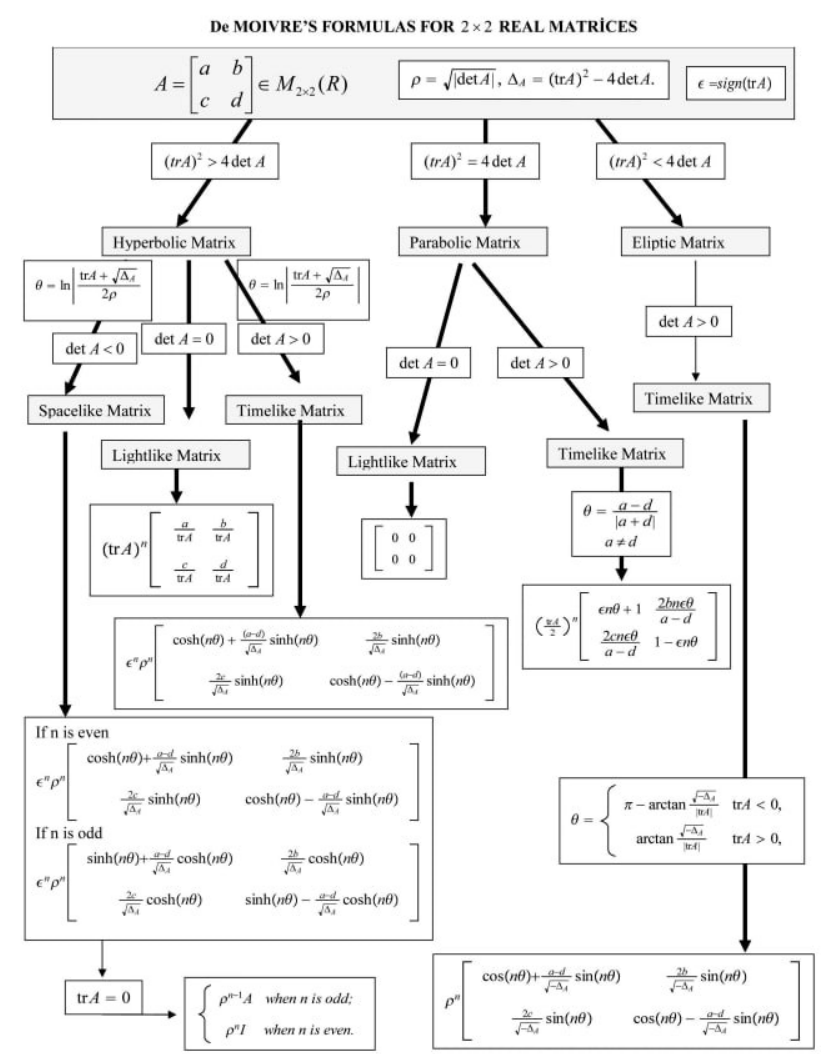

In [14]:
def power_matrix_2_2(A, n):
  '''
  Вычисляет степень матрицы для всех возможных случаев
  '''
  trA = np.trace(A)
  detA = np.linalg.det(A)
  if trA == 0:
      if n % 2 == 0:
        k = n // 2
        if k % 2 == 0 or detA < 0:
          signum = 1
        else:
          signum = -1
        return signum*(abs(detA)**k)*np.array([
        [1, 0],
        [0, 1]
    ])
      else:
        k = (n - 1) // 2
        if k % 2 == 0 or detA < 0:
          signum = 1
        else:
          signum = -1
        return signum*(abs(detA)**k)*A


  dA = trA**2 - 4*detA
  if dA > 0:  # гиперболические матрицы
    if detA < 0:  # пространственно-подобные матрицы
      if n%2 == 0:
        return power_hyperbolic_matrix_even(A, n, trA, detA, dA)
      else:
        return power_hyperbolic_matrix_odd(A, n, trA, detA, dA)
    if detA > 0: # времениподобные матрицы
       return power_hyperbolic_matrix_even(A, n, trA, detA, dA)
    if detA == 0: # светоподобные матрицы
      return (trA**(n-1))*A

  elif dA < 0: # эллиптические матрицы, они все времениподобные
    return power_elliptic_matrix(A, n, trA, detA, dA)

  else: # параболические матрицы, у них одинаковые собственные числа
    if detA > 0: # пространственно-подобные (времениподобных не может быть)
      return power_parabolic_matrix(A, n, trA, detA, dA)
    else:  # светоподобная параболическая матрица одна - нулевая
      return np.array([
        [0, 0],
        [0, 0]
    ])

  return -1




def power_hyperbolic_matrix_even(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень гиперболической матрицы 2x2 (det(A) < 0, n - четное).

    """
    p = np.sqrt(np.abs(detA))  # Так как detA < 0, используем abs
    a, b, c, d = A.flatten()
    pA = dA**0.5
    try:
      theta = math.log(abs((trA + pA) / (2 * p)))
    except:
      print(A, 'математическая ошибка', 'detA = ', detA)
    thn = n*theta
    cosh_ntheta = np.cosh(thn)
    sinh_ntheta = np.sinh(thn)
    spA = sinh_ntheta/pA
    adspA = (a-d)*spA

    a11 = cosh_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = cosh_ntheta - adspA
    signum = 1
    if n % 2 != 0:
      if trA < 0:
        signum = -1

    result = signum*(abs(detA)**(n/2))*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_hyperbolic_matrix_odd(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень гиперболической матрицы 2x2 (det(A) < 0, n - нечетное).

    """

    p = np.sqrt(np.abs(detA))  # Так как detA < 0, используем abs

    a, b, c, d = A.flatten()


    pA = dA**0.5
    try:
      theta = math.log(abs((trA + pA) / (2 * p)))
    except:
      print(A, 'математическая ошибка', 'detA = ', detA)
    thn = n*theta
    cosh_ntheta = np.cosh(thn)
    sinh_ntheta = np.sinh(thn)

    spA = cosh_ntheta/pA
    adspA = (a-d)*spA

    a11 = sinh_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = sinh_ntheta - adspA

    if trA > 0:
      signum = 1
    else:
      signum = -1

    signum = 1

    result = signum*(abs(detA)**(n/2))*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_elliptic_matrix(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень эллиптической матрицы 2x2 (det(A) > 0).

    Args:
        A: Матрица 2x2 (NumPy array).
        n: Целое неотрицательное число.

    Returns:
        n-ая степень матрицы A (NumPy array).
        Возвращает None, если det(A) <= 0.
    """
    a, b, c, d = A.flatten()
    pA = (abs(dA))**0.5
    theta = np.arctan2(pA, trA)
    p = np.sqrt(np.abs(detA))  # Так как detA может быть < 0, используем abs

    cos_ntheta = np.cos(n * theta)
    sin_ntheta = np.sin(n * theta)
    spA = sin_ntheta/pA
    adspA = (a-d)*spA

    a11 = cos_ntheta + adspA
    a12 = (b*spA * 2)
    a21 = (c*spA * 2)
    a22 = cos_ntheta - adspA

    result = (p**n)*np.array([
        [a11, a12],
        [a21, a22]
    ])

    return result

def power_parabolic_matrix(A, n, trA, detA, dA):
    """
    Вычисляет n-ую степень параболической матрицы 2x2 (det(A) = 0).

    Args:
        A: Матрица 2x2 (NumPy array).
        n: Целое неотрицательное число.

    Returns:
        n-ая степень матрицы A (NumPy array).
        Возвращает None, если det(A) != 0.
    """

    a, b, c, d = A.flatten()
    t = abs(trA)
    theta = (a-d)/t

    if trA > 0:
      signum = 1
    else:
      signum = -1

    q = signum*n*theta
    a11 = 1 + q
    a12 = (b*n * 2)/(trA)
    a21 = (c*n * 2)/(trA)
    a22 = 1 - q

    result = ((0.5*trA)**n)*np.array([
        [a11, a12],
        [a21, a22]
    ])
    return result

'''
A = np.array([
    [-10, -5],
    [  6,  3]
] )

result = power_matrix_2_2(A, 1)
print(result)

'''

def test_matrix_power():
    num_tests = 10  # Количество тестов
    max_power = 5   # Максимальная степень для тестирования
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)

        for n in range(1, max_power + 1):
            result = power_matrix_2_2(A, n)
            expected_result = np.linalg.matrix_power(A, n)
            error = np.linalg.norm(result - expected_result, ord=2)
            flag = (error > 0.001)
            # Вывод результатов
            if flag:
              print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по второй норме: {error}\n")
              if error > 0.1:
                print(det_A)
    return -1

# Запуск тестирования
test_matrix_power()



-1

**Выводы по тестированию.**

Было протестировано огромное количество матриц, элементы которых - целые числа, не превышающие по модулю 10. Посчитаны степени от 1 до 10.
Были сделаны следующие выводы:

- для подавляющего большинства матриц относительная ошибка вычисления элементов степени матрицы была по порядку не больше, чем $10^{-16}$, что соответствует вычислению на уровне машинной погрешности

- для небольшой части матриц погрешность сильно выше, таких матриц в среднем несколько штук на 50000 случайных матриц

- совершенно неверно считает матрицы, определитель которых почти равен нулю. Например, в некоторых случаях определитель матрицы с нулевым определителем находит как очень небольшое число, близкое к машинной погрешности. В таких случаях либо выдает math domain error при вычислении логарифма, либо просто вычисляет с очень большой ошибкой. В таких случаях абсолютное значение определителя определяется в диапазоне от $4 \cdot 10^{-15}$ до $9 \cdot 10^{-15}$. Возможное решение - при столь малых значениях принимать равным нулю. А при малых значениях определителя модифицировать формулу.

- в матрицах, в которых диагональные элементы равны, а один из внедиагональных элементов равен нулю, погрешность иногда может оказаться больше 0.001. Пример

Матрица A:

$$
\begin{aligned}
& {\left[\begin{array}{ll}
-9 & -8
\end{array}\right]} \\
& {\left[\begin{array}{rr}
0 & -9
\end{array}\right]}
\end{aligned}
$$

Степень n: 5

Результат:

-59049.0  $\ \ \ $  -262439.9961182

0.0 $\ \ \ \ \ \ \ \ \ \ \ \ $          -59049.0

Ожидаемый результат:

-59049 $\ \ \ $ -262440

0 $\ \ \ \ \ \ \ \ \ \ \ \ $ -59049

Ошибка по второй норме: 0.0038818043540231988


Эта ошибка в данном примере возникла из-за того, что число $\Delta_A=(\operatorname{tr} A)^2-4 \operatorname{det} A$, которое для этой матрицы строго равно нулю, было определено как отрицательное число по модулю порядка машинной погрешности, и при вычислении отношения синуса от него к аргументу возникла погрешность больше обычного.

**Итоговый вывод.**

Проблемы в аналитическом алгоритме возникают в основном в дробях при делении на число, почти не отличающееся от нуля. В случаях, когда числитель тоже очень мало, доработкой алгоритма можно устранить эту погрешность. Но если числитель намного больше знаменателя, то сама задача плохо обусловлена и может возникнуть проблема с неустранимой погрешностью округления. Впрочем, и здесь, модифицировав формулы, можно увеличить точность вычислений, предложив альтернативные формулы.

##### Метод быстрого вычисления по прямой формуле со степенями

$$
\begin{gathered}
\alpha_n=(r+u)^n \quad \beta_n=(u-r)^n ; A^n=\frac{\alpha_n+\beta_n}{2} I+\frac{\alpha_n-\beta_n}{2 r}\left(v e_1+w e_2+t e_{12}\right) \\
r=\sqrt{w^2+v^2-t^2} ; \quad u=\frac{a+d}{2}, \quad v=\frac{a-d}{2}, \quad w=\frac{b+c}{2}, \quad t=\frac{b-c}{2} \\
\left(\begin{array}{cc}
a & b \\
c & d
\end{array}\right)=u \cdot \mathbf{I}+v \cdot \mathbf{e}_1+w \cdot \mathbf{e}_2+t \cdot \mathbf{e}_{12} \\
\mathbf{e}_1=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right), \quad \mathbf{e}_2=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \mathbf{e}_{12}=\left(\begin{array}{cc}
0 & 1 \\
-1 & 0
\end{array}\right)
\end{gathered}
$$

Вычисление по этой формуле напрямую может быть плохо обусловлено, если $r → 0$.

Важным преимуществом этой формулы является то, что она единым образом вычисляет любые степени комплексной матрицы, в том числе отрицательные, дробные, комплексные. Кроме того, она может быть переписана следующим образом

$$
f(A)=\frac{f\left(\lambda_{+}\right)+f\left(\lambda_{-}\right)}{2} I+\frac{A-\left(\frac{\operatorname{tr}(A)}{2}\right) I}{\sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|}} \frac{f\left(\lambda_{+}\right)-f\left(\lambda_{-}\right)}{2}
$$

где $f(x) = x^n$

Первый вид этих формул чуть удобнее для анализа того, что делать при малых $r$. Если $u > r$, то удобнее вынести $u^n$ за скобки.

Если $r$ порядка машинной погрешности, то заменить на производную. Более того, ошибка имеет порядок $O(r^2)$ при $r → 0$.

Однако для такого пренебрежения важна малость именно отношения $r/u$.

In [5]:
def matrix_power_analytic(A, n):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r = (u*u - det_A)**0.5 ;

    q1, q2 = (u + r)**n, (u - r)**n
    p1 = 0.5*(q1 + q2)
    p2 = 0
    if abs(r) < abs(u):
      t = r/u
      if abs(t) < 10**(-14):
        p2 = n*(u**(n-1))
      else:
        p2 = (u**n)*((1+t)**n - (1-t)**n)*0.5/r
    elif abs(r) >= abs(u):
      t = u/r
      p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5

    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    # Применяем формулу
    result = p1*I + p2*(A - u*I)


    return result

def test_matrix_power2():
    num_tests = 10 # Количество тестов
    max_power = 5   # Максимальная степень для тестирования
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)

        for n in range(1, max_power + 1):
            result = matrix_power_analytic(A, n)
            expected_result = np.linalg.matrix_power(A, n)
            error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
            flag = (error > 10**(-15))
            # Вывод результатов
            if flag:
              print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
              if error > 0.1:
                print(det_A)
    return -1

# Запуск тестирования
test_matrix_power2()




<ipython-input-5-9e2a1917ca48>:8: RuntimeWarning: invalid value encountered in scalar power
  r = (u*u - det_A)**0.5 ;


-1

Результаты тестирования этой программы на матрицах с целыми числами и натуральными степенями показывают, что ответ получается абсолютно точным. Пришлось заменить норму ошибки на норму Фробениуса, так как вторую норму не получается посчитать от нулевой матрицы встроенным алгоритмом. Протестируем на дробных степенях

In [188]:
def test_matrix_power3():
    num_tests = 10 # Количество тестов
    max_power = 18  # Максимальная степень для тестирования
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)

        for k in range(1, max_power + 1):
            n = k**0.5
            result = matrix_power_analytic(A, n)
            expected_result = fractional_matrix_power(A, n)
            error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
            flag = (error > 10**(-15))
            # Вывод результатов
            if flag:
              print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
              if error > 0.1:
                print(det_A)
    return -1

# Запуск тестирования
test_matrix_power3()

<ipython-input-179-9e2a1917ca48>:10: RuntimeWarning: invalid value encountered in scalar power
  q1, q2 = (u + r)**n, (u - r)**n
<ipython-input-179-9e2a1917ca48>:21: RuntimeWarning: invalid value encountered in scalar power
  p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5
<ipython-input-179-9e2a1917ca48>:8: RuntimeWarning: invalid value encountered in scalar power
  r = (u*u - det_A)**0.5 ;


Матрица A:
[[ 7 -5]
 [ 0  5]]
Степень n: 2.23606797749979
Результат:
[[  77.57051327 -102.53927649]
 [   0.           36.55480268]]
Ожидаемый результат:
[[  77.57051327 -102.53927649]
 [   0.           36.55480268]]
Ошибка по норме Фробениуса: 1.7371647234583815e-15

Матрица A:
[[ 7 -5]
 [ 0  5]]
Степень n: 2.449489742783178
Результат:
[[ 117.50571263 -164.92156745]
 [   0.           51.53708565]]
Ожидаемый результат:
[[ 117.50571263 -164.92156745]
 [   0.           51.53708565]]
Ошибка по норме Фробениуса: 1.4977362511837217e-15

Матрица A:
[[ 7 -5]
 [ 0  5]]
Степень n: 3.3166247903554
Результат:
[[  635.14533083 -1067.67422111]
 [    0.           208.07564239]]
Ожидаемый результат:
[[  635.14533083 -1067.67422111]
 [    0.           208.07564239]]
Ошибка по норме Фробениуса: 1.1821785801751144e-15



-1

Погрешность остается очень малой, на любых матрицах.

Можно также сравнить между собой скорость работы нашей реализации и встроенной.

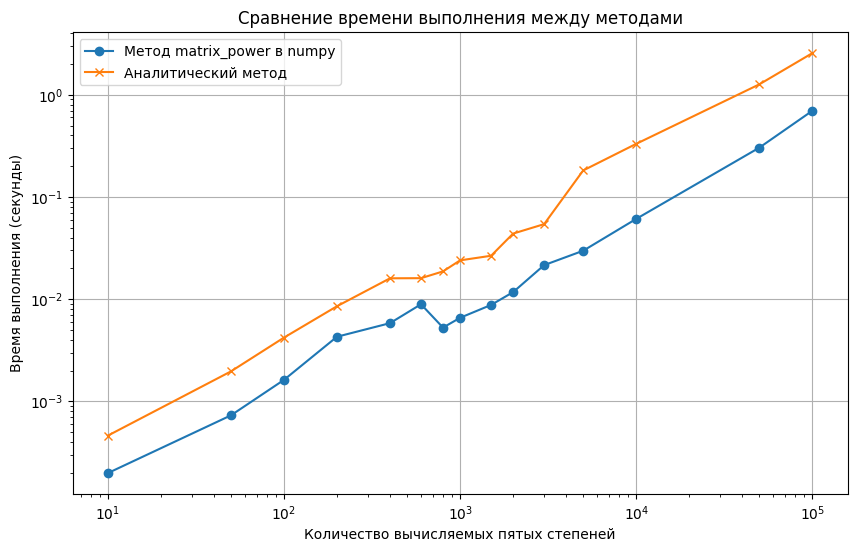

Количество степеней: 10, Время выполнения (scipy): 0.000199 секунд, Время выполнения (R): 0.000463 секунд
Количество степеней: 50, Время выполнения (scipy): 0.000731 секунд, Время выполнения (R): 0.001968 секунд
Количество степеней: 100, Время выполнения (scipy): 0.001625 секунд, Время выполнения (R): 0.004212 секунд
Количество степеней: 200, Время выполнения (scipy): 0.004295 секунд, Время выполнения (R): 0.008540 секунд
Количество степеней: 400, Время выполнения (scipy): 0.005834 секунд, Время выполнения (R): 0.016020 секунд
Количество степеней: 600, Время выполнения (scipy): 0.008928 секунд, Время выполнения (R): 0.016067 секунд
Количество степеней: 800, Время выполнения (scipy): 0.005277 секунд, Время выполнения (R): 0.018711 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.006582 секунд, Время выполнения (R): 0.023996 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.008794 секунд, Время выполнения (R): 0.026618 секунд
Количество степеней: 2000, Время выпо

In [198]:
A = np.array([[1, 2], [3, 4]])

q = 5

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых пятых степеней')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

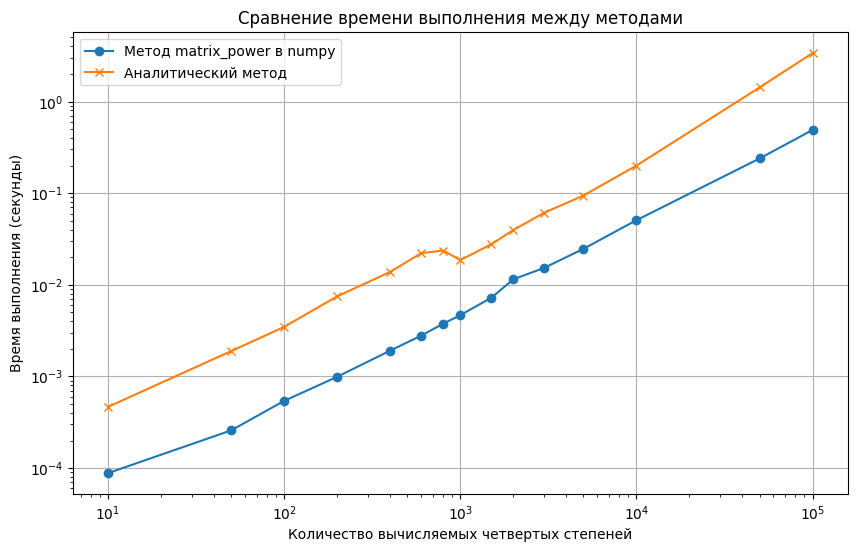

Количество степеней: 10, Время выполнения (scipy): 0.000088 секунд, Время выполнения (R): 0.000466 секунд
Количество степеней: 50, Время выполнения (scipy): 0.000258 секунд, Время выполнения (R): 0.001890 секунд
Количество степеней: 100, Время выполнения (scipy): 0.000541 секунд, Время выполнения (R): 0.003474 секунд
Количество степеней: 200, Время выполнения (scipy): 0.000992 секунд, Время выполнения (R): 0.007489 секунд
Количество степеней: 400, Время выполнения (scipy): 0.001915 секунд, Время выполнения (R): 0.013830 секунд
Количество степеней: 600, Время выполнения (scipy): 0.002790 секунд, Время выполнения (R): 0.022177 секунд
Количество степеней: 800, Время выполнения (scipy): 0.003768 секунд, Время выполнения (R): 0.023687 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.004661 секунд, Время выполнения (R): 0.018598 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.007223 секунд, Время выполнения (R): 0.027706 секунд
Количество степеней: 2000, Время выпо

In [197]:
A = np.array([[1, 2], [3, 4]])

q = 4

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых четвертых степеней')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

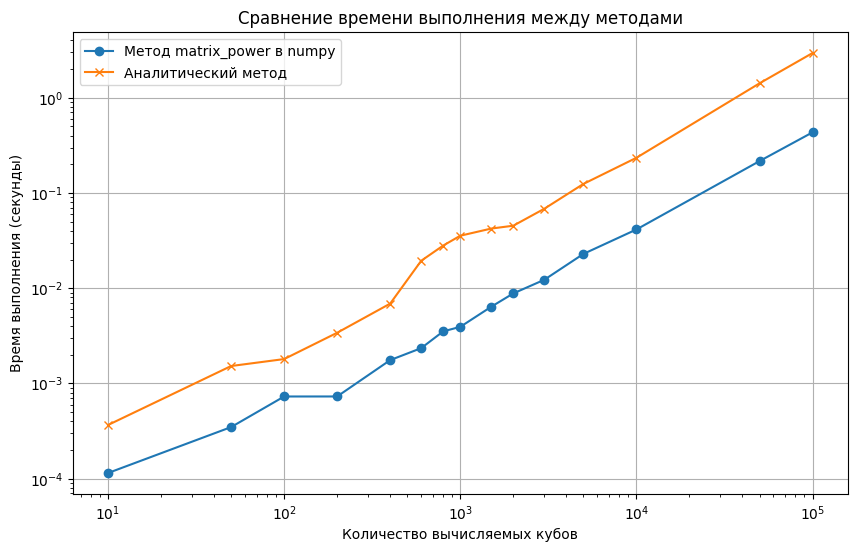

Количество степеней: 10, Время выполнения (scipy): 0.000114 секунд, Время выполнения (R): 0.000365 секунд
Количество степеней: 50, Время выполнения (scipy): 0.000348 секунд, Время выполнения (R): 0.001522 секунд
Количество степеней: 100, Время выполнения (scipy): 0.000728 секунд, Время выполнения (R): 0.001801 секунд
Количество степеней: 200, Время выполнения (scipy): 0.000729 секунд, Время выполнения (R): 0.003402 секунд
Количество степеней: 400, Время выполнения (scipy): 0.001756 секунд, Время выполнения (R): 0.006884 секунд
Количество степеней: 600, Время выполнения (scipy): 0.002345 секунд, Время выполнения (R): 0.019398 секунд
Количество степеней: 800, Время выполнения (scipy): 0.003518 секунд, Время выполнения (R): 0.028028 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.003925 секунд, Время выполнения (R): 0.035545 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.006388 секунд, Время выполнения (R): 0.042273 секунд
Количество степеней: 2000, Время выпо

In [196]:
A = np.array([[1, 2], [3, 4]])

q = 3

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых кубов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

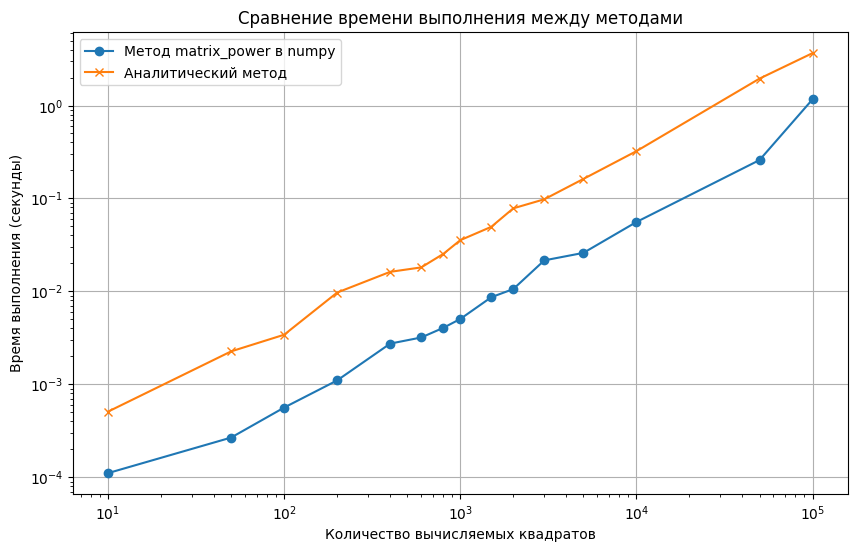

Количество степеней: 10, Время выполнения (scipy): 0.000111 секунд, Время выполнения (R): 0.000508 секунд
Количество степеней: 50, Время выполнения (scipy): 0.000268 секунд, Время выполнения (R): 0.002263 секунд
Количество степеней: 100, Время выполнения (scipy): 0.000562 секунд, Время выполнения (R): 0.003417 секунд
Количество степеней: 200, Время выполнения (scipy): 0.001102 секунд, Время выполнения (R): 0.009717 секунд
Количество степеней: 400, Время выполнения (scipy): 0.002743 секунд, Время выполнения (R): 0.016235 секунд
Количество степеней: 600, Время выполнения (scipy): 0.003192 секунд, Время выполнения (R): 0.018117 секунд
Количество степеней: 800, Время выполнения (scipy): 0.004050 секунд, Время выполнения (R): 0.025272 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.005048 секунд, Время выполнения (R): 0.035564 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.008658 секунд, Время выполнения (R): 0.049522 секунд
Количество степеней: 2000, Время выпо

In [195]:
A = np.array([[1, 2], [3, 4]])

q = 2

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых квадратов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

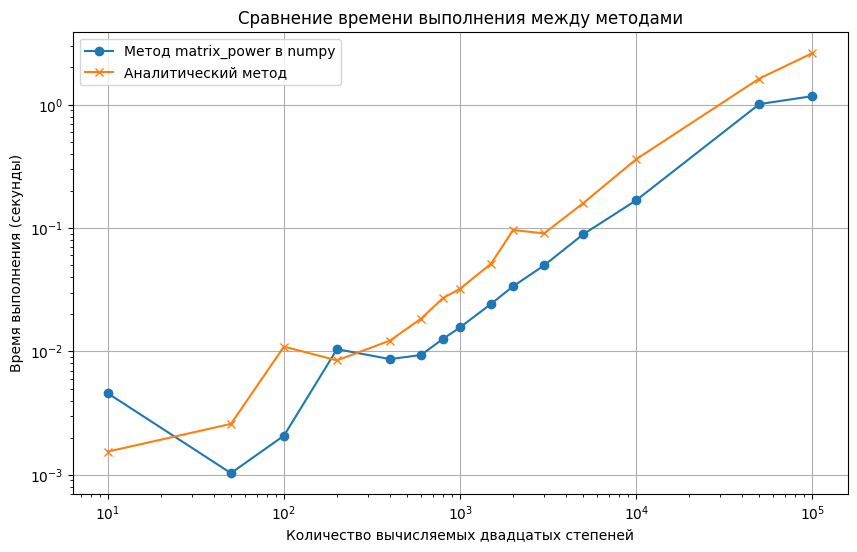

Количество степеней: 10, Время выполнения (scipy): 0.004578 секунд, Время выполнения (R): 0.001542 секунд
Количество степеней: 50, Время выполнения (scipy): 0.001032 секунд, Время выполнения (R): 0.002585 секунд
Количество степеней: 100, Время выполнения (scipy): 0.002075 секунд, Время выполнения (R): 0.010932 секунд
Количество степеней: 200, Время выполнения (scipy): 0.010423 секунд, Время выполнения (R): 0.008459 секунд
Количество степеней: 400, Время выполнения (scipy): 0.008664 секунд, Время выполнения (R): 0.012235 секунд
Количество степеней: 600, Время выполнения (scipy): 0.009348 секунд, Время выполнения (R): 0.018406 секунд
Количество степеней: 800, Время выполнения (scipy): 0.012632 секунд, Время выполнения (R): 0.027064 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.015667 секунд, Время выполнения (R): 0.032214 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.024289 секунд, Время выполнения (R): 0.051435 секунд
Количество степеней: 2000, Время выпо

In [200]:
A = np.array([[1, 2], [3, 4]])

q = 20

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых двадцатых степеней')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

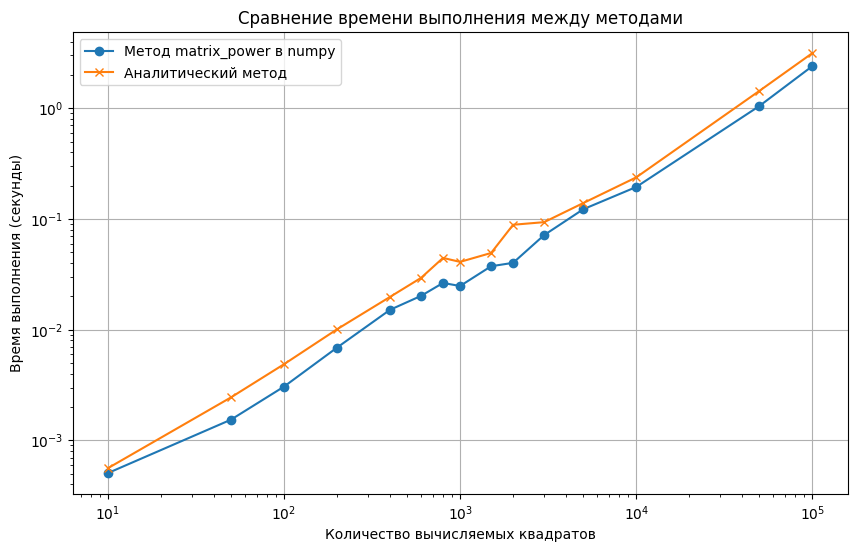

Количество степеней: 10, Время выполнения (scipy): 0.000506 секунд, Время выполнения (R): 0.000560 секунд
Количество степеней: 50, Время выполнения (scipy): 0.001538 секунд, Время выполнения (R): 0.002445 секунд
Количество степеней: 100, Время выполнения (scipy): 0.003057 секунд, Время выполнения (R): 0.004872 секунд
Количество степеней: 200, Время выполнения (scipy): 0.006884 секунд, Время выполнения (R): 0.010076 секунд
Количество степеней: 400, Время выполнения (scipy): 0.015112 секунд, Время выполнения (R): 0.019765 секунд
Количество степеней: 600, Время выполнения (scipy): 0.020195 секунд, Время выполнения (R): 0.029357 секунд
Количество степеней: 800, Время выполнения (scipy): 0.026431 секунд, Время выполнения (R): 0.044483 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.024803 секунд, Время выполнения (R): 0.040964 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.037415 секунд, Время выполнения (R): 0.049293 секунд
Количество степеней: 2000, Время выпо

In [201]:
A = np.array([[1, 2], [3, 4]])

q = -2

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      np.linalg.matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод matrix_power в numpy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых квадратов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

Теперь сравним с функцией вычисления дробных степеней.

<ipython-input-179-9e2a1917ca48>:10: RuntimeWarning: invalid value encountered in scalar power
  q1, q2 = (u + r)**n, (u - r)**n
<ipython-input-179-9e2a1917ca48>:21: RuntimeWarning: invalid value encountered in scalar power
  p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5


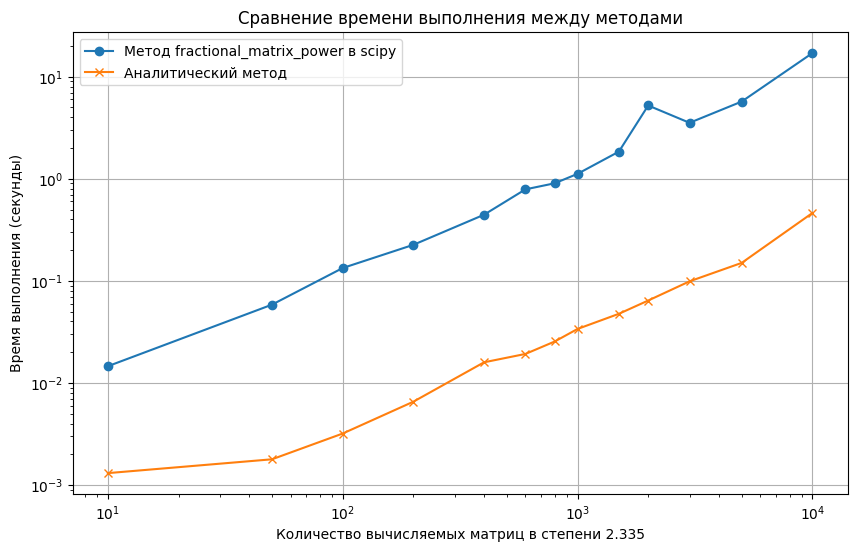

Количество степеней: 10, Время выполнения (scipy): 0.014578 секунд, Время выполнения (R): 0.001307 секунд
Количество степеней: 50, Время выполнения (scipy): 0.058470 секунд, Время выполнения (R): 0.001786 секунд
Количество степеней: 100, Время выполнения (scipy): 0.133583 секунд, Время выполнения (R): 0.003193 секунд
Количество степеней: 200, Время выполнения (scipy): 0.225527 секунд, Время выполнения (R): 0.006550 секунд
Количество степеней: 400, Время выполнения (scipy): 0.444829 секунд, Время выполнения (R): 0.015930 секунд
Количество степеней: 600, Время выполнения (scipy): 0.788174 секунд, Время выполнения (R): 0.019233 секунд
Количество степеней: 800, Время выполнения (scipy): 0.904253 секунд, Время выполнения (R): 0.025478 секунд
Количество степеней: 1000, Время выполнения (scipy): 1.118044 секунд, Время выполнения (R): 0.033791 секунд
Количество степеней: 1500, Время выполнения (scipy): 1.845243 секунд, Время выполнения (R): 0.047562 секунд
Количество степеней: 2000, Время выпо

In [203]:
A = np.array([[1, 2], [3, 4]])

q = 2.335

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000] #50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      fractional_matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод fractional_matrix_power в scipy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых матриц в степени 2.335')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

<ipython-input-179-9e2a1917ca48>:10: RuntimeWarning: invalid value encountered in scalar power
  q1, q2 = (u + r)**n, (u - r)**n
<ipython-input-179-9e2a1917ca48>:21: RuntimeWarning: invalid value encountered in scalar power
  p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5


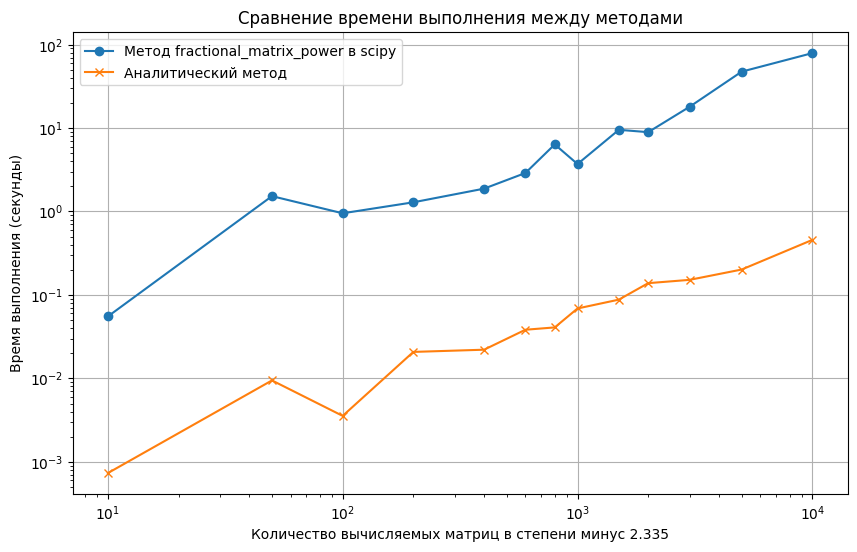

In [204]:
A = np.array([[1, 2], [3, 4]])

q = -2.335

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000] #50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      fractional_matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_power_analytic(A, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод fractional_matrix_power в scipy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод')
plt.xlabel('Количество вычисляемых матриц в степени минус 2.335')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [205]:
# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

Количество степеней: 10, Время выполнения (scipy): 0.055180 секунд, Время выполнения (R): 0.000732 секунд
Количество степеней: 50, Время выполнения (scipy): 1.526783 секунд, Время выполнения (R): 0.009457 секунд
Количество степеней: 100, Время выполнения (scipy): 0.951416 секунд, Время выполнения (R): 0.003553 секунд
Количество степеней: 200, Время выполнения (scipy): 1.288175 секунд, Время выполнения (R): 0.020760 секунд
Количество степеней: 400, Время выполнения (scipy): 1.877531 секунд, Время выполнения (R): 0.022062 секунд
Количество степеней: 600, Время выполнения (scipy): 2.891839 секунд, Время выполнения (R): 0.038275 секунд
Количество степеней: 800, Время выполнения (scipy): 6.361767 секунд, Время выполнения (R): 0.040813 секунд
Количество степеней: 1000, Время выполнения (scipy): 3.702780 секунд, Время выполнения (R): 0.068814 секунд
Количество степеней: 1500, Время выполнения (scipy): 9.520500 секунд, Время выполнения (R): 0.087835 секунд
Количество степеней: 2000, Время выпо

 **Вывод.**

 Встроенная функция вычисления целых степеней работает лучше. Она использует матричное возведение в квадрат и умножение матриц, для отрицательных степеней - также обращение матрицы.

 Встроенная функция для дробных степеней работает намного хуже. В случае положительных дробных степеней выигрыш в несколько десятков раз (на тестах обычно было около 40) без потери точности.  

 В случае отрицательных дробных степеней выигрыш во времени в сотни раз (на тестах с разными матрицами было около 200).

#### Вычисление матричной экспоненты.

##### Скорость вычисления экспонент встроенным алгоритмом.

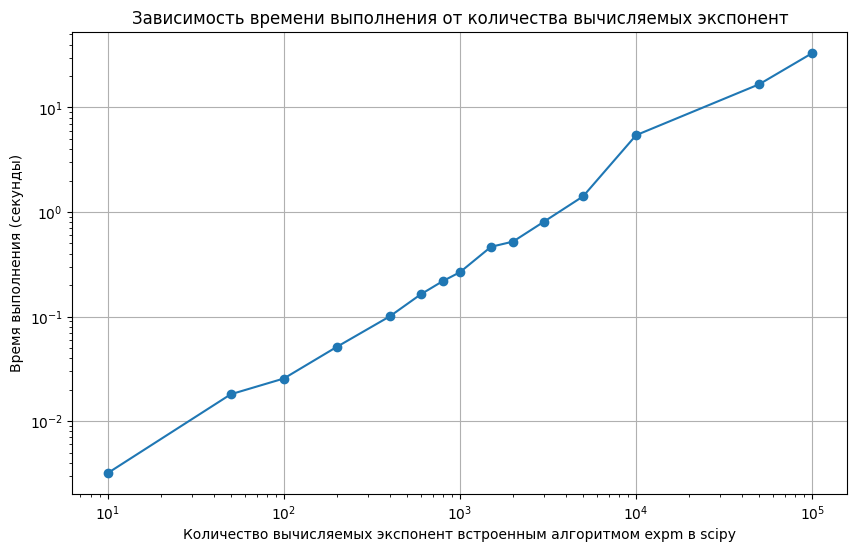

Количество экспонент: 10, Время выполнения: 0.003178 секунд
Количество экспонент: 50, Время выполнения: 0.018058 секунд
Количество экспонент: 100, Время выполнения: 0.025544 секунд
Количество экспонент: 200, Время выполнения: 0.051293 секунд
Количество экспонент: 400, Время выполнения: 0.100538 секунд
Количество экспонент: 600, Время выполнения: 0.163436 секунд
Количество экспонент: 800, Время выполнения: 0.218542 секунд
Количество экспонент: 1000, Время выполнения: 0.265608 секунд
Количество экспонент: 1500, Время выполнения: 0.464647 секунд
Количество экспонент: 2000, Время выполнения: 0.521173 секунд
Количество экспонент: 3000, Время выполнения: 0.808671 секунд
Количество экспонент: 5000, Время выполнения: 1.411941 секунд
Количество экспонент: 10000, Время выполнения: 5.433566 секунд
Количество экспонент: 50000, Время выполнения: 16.683970 секунд
Количество экспонент: 100000, Время выполнения: 33.121636 секунд


In [19]:
A = np.array([[1, 0], [0, 1]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []

for n in num_exponents:
    perturbations = np.random.uniform(-10.01, 10.01, (n, 2, 2))

    start_time = time.time()
    for perturbation in perturbations:
        perturbed_A = A + perturbation
        expm(perturbed_A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o')
plt.xlabel('Количество вычисляемых экспонент встроенным алгоритмом expm в scipy')
plt.ylabel('Время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вычисляемых экспонент')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.show()

for n, t in zip(num_exponents, execution_times):
    print(f"Количество экспонент: {n}, Время выполнения: {t:.6f} секунд")

Точность встроенного алгоритма близка к машинной

In [35]:
A_test = np.array([[1, 2], [3 , 4 ]])
A2_test = logm(expm(A_test))
np.linalg.norm(A2_test - A_test, ord=2)/np.linalg.norm(A_test, ord=2)


3.7918467655530665e-15

##### Скорость вычисления экспонент аппроксимацией Паде четвертого порядка

Аппроксимации Паде экспоненты имеют следующий вид

$$
\mathrm{e}^{t \mathbf{A}} \approx R_{k j}(t \mathbf{A})=\left(Q_{k j}(t \mathbf{A})\right)^{-1} P_{k j}(t \mathbf{A}),
$$

В частности, можно использовать следующие.

$$
\begin{aligned}
R_{12}(t \mathbf{A})= & \left(6 \mathbf{E}-4 t \mathbf{A}+(t \mathbf{A})^2\right)^{-1}(6 \mathbf{E}+2 t \mathbf{A})= \\
& =2 \operatorname{Re}\left(y_1\left(t \mathbf{A}-z_1 \mathbf{E}\right)^{-1}\right)
\end{aligned}
$$


где $z_1=2-i \sqrt{2}-$ корень многочлена $6-4 z+z^2$, $y_1=1+i \frac{5}{\sqrt{2}}$

$$
\begin{aligned}
& \begin{aligned}
& R_{22}(t \mathbf{A})=\left(12 \mathbf{E}-6 t \mathbf{A}+(t \mathbf{A})^2\right)^{-1}\left(12 \mathbf{E}+6 t \mathbf{A}+(t \mathbf{A})^2\right)= \\
& \quad=\mathbf{E}+2 \operatorname{Re}\left(y_1\left(t \mathbf{A}-z_1 \mathbf{E}\right)^{-1}\right)
\end{aligned}
\end{aligned}
$$


где $z_1=3-i \sqrt{3}-$ корень многочлена $12-6 z+z^2$, $y_1=6+i 6 \sqrt{3}$.

$$
\begin{array}{r}
R_{44}(t \mathbf{A})=\left(1680 \mathbf{E}-840 t \mathbf{A}+180(t \mathbf{A})^2-20(t \mathbf{A})^3+\right. \\
\left.+(t \mathbf{A})^4\right)^{-1}\left(1680 \mathbf{E}+840 t \mathbf{A}+180(t \mathbf{A})^2+20(t \mathbf{A})^3+(t \mathbf{A})^4\right)
\end{array}
$$

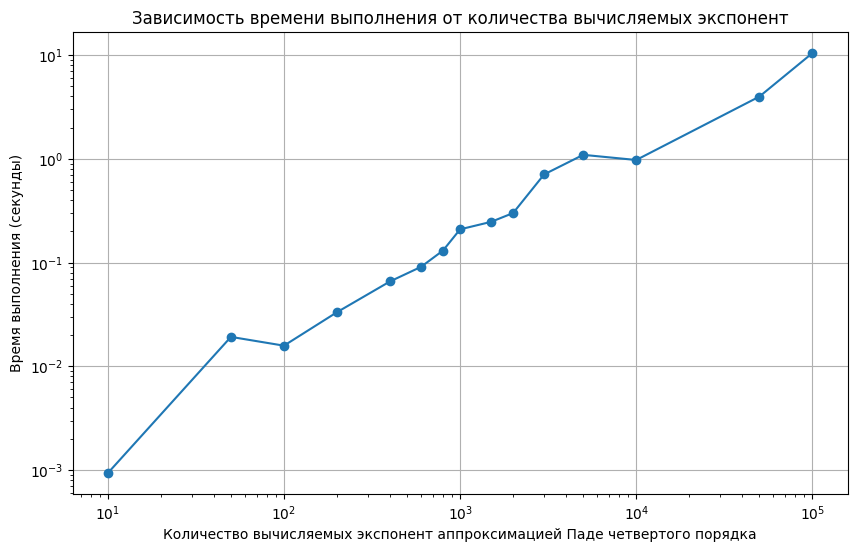

Количество экспонент: 10, Время выполнения: 0.000933 секунд
Количество экспонент: 50, Время выполнения: 0.019192 секунд
Количество экспонент: 100, Время выполнения: 0.015791 секунд
Количество экспонент: 200, Время выполнения: 0.033188 секунд
Количество экспонент: 400, Время выполнения: 0.065700 секунд
Количество экспонент: 600, Время выполнения: 0.090775 секунд
Количество экспонент: 800, Время выполнения: 0.130432 секунд
Количество экспонент: 1000, Время выполнения: 0.208829 секунд
Количество экспонент: 1500, Время выполнения: 0.246535 секунд
Количество экспонент: 2000, Время выполнения: 0.299757 секунд
Количество экспонент: 3000, Время выполнения: 0.706836 секунд
Количество экспонент: 5000, Время выполнения: 1.091066 секунд
Количество экспонент: 10000, Время выполнения: 0.973037 секунд
Количество экспонент: 50000, Время выполнения: 3.972268 секунд
Количество экспонент: 100000, Время выполнения: 10.428939 секунд


In [22]:
A = np.array([[1, 0], [0, 1]])

def exp_R44(A, t):
    E = np.eye(2)
    tA = t * A
    tA_squared = np.dot(tA, tA)
    R_44_numerator = (1680 * E + 840 * tA + 180 * tA_squared +
                      20 * np.dot(tA_squared, tA) +
                      np.dot(tA_squared, tA_squared))
    R_44_denominator = (1680 * E - 840 * tA + 180 * tA_squared -
                        20 * np.dot(tA_squared, tA) +
                        np.dot(tA_squared, tA_squared))
    R_44 = np.linalg.inv(R_44_denominator) @ R_44_numerator
    return R_44

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []

for n in num_exponents:
    perturbations = np.random.uniform(-10.01, 10.01, (n, 2, 2))

    start_time = time.time()
    for perturbation in perturbations:
        perturbed_A = A + perturbation
        exp_R44(perturbed_A, 1)
    end_time = time.time()

    execution_times.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o')
plt.xlabel('Количество вычисляемых экспонент аппроксимацией Паде четвертого порядка')
plt.ylabel('Время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вычисляемых экспонент')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.show()

for n, t in zip(num_exponents, execution_times):
    print(f"Количество экспонент: {n}, Время выполнения: {t:.6f} секунд")

Однако точность такого метода оставляет желать лучшего. Хорошая точность получается, только если матрица имеет маленькую норму, порядка единицы или меньше.

In [23]:
A_test = np.array([[1, 2], [3 , 4 ]])
expm(A_test)

array([[ 51.9689562 ,  74.73656457],
       [112.10484685, 164.07380305]])

In [25]:
exp_R44(A_test,1)

array([[ 39.34398117,  56.33658373],
       [ 84.50487559, 123.84885676]])

##### Метод масштабирования и возведения в квадрат с аппроксимацией Паде.

Он используется в библиотечных реализациях, где в зависимиости от матрицы алгоритмм подбирает подходящий порядок аппроксимации Паде, нужный для достижения максимальной точности.

Этот метод использует соотношение $e^A=\left(e^{A / \sigma}\right)^\sigma$ для $A \in \mathbb{C}^{n \times n}$ и $\sigma \in \mathbb{C}$, а также тот факт, что $e^A$ хорошо аппроксимируется аппроксимацией Тейлора или Паде вблизи начала координат, то есть для малых $\|A\|$. Идея состоит в том, чтобы выбрать $\sigma$ целую степень 2 , скажем, $\sigma=2^s$, так, чтобы $A / \sigma$ имела норму порядка 1 ; аппроксимация $e^{A / 2^s} \approx r\left(A / 2^s\right)$, где $r$ - аппроксимация Тейлора или Паде экспоненты; а затем возьмем $e^A \approx r\left(A / 2^s\right)^{2^s}$, где аппроксимация формируется повторным возведением в квадрат $s$.

Аппроксимацию Паде произвольного порядка можно вычислять по формуле

$$
\begin{gathered}
p_{k m}(A)=\sum_{j=0}^k \frac{(k+m-j)!k!}{(k+m)!(k-j)!} \frac{A^j}{j!}, \quad q_{k m}(A)=\sum_{j=0}^m \frac{(k+m-j)!m!}{(k+m)!(m-j)!} \frac{(-A)^j}{j!} \\
r_{k m}(A)=p_{k m}(A) / q_{k m}(A)
\end{gathered}
$$


Элементами матрицы могут быть любые комплексные числа.

Можно повысить точность, если поделить матрицу на степень двойки, ближайшую к ее норме (так чтобы получилась матрица с нормой, не большей единицы), взять экспоненту, а потом возвести несколько раз в квадрат.

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


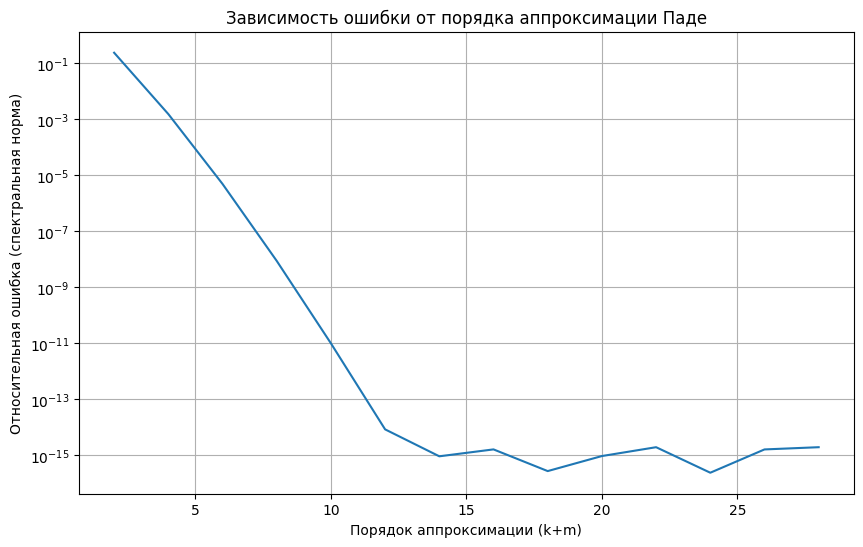

R:
[[ 51.96895574+0.j  74.7365639 +0.j]
 [112.10484585+0.j 164.0738016 +0.j]]


In [62]:
def pade_approximation(A, k, m):
    n = A.shape[0]
    P = np.zeros((n, n), dtype=complex)
    Q = np.zeros((n, n), dtype=complex)
    H = np.eye(n, dtype=complex)
    signum = 1
    for j in range(k + 1):

        P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
        Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H
        H = H @ A
        signum = -signum

    '''  В нашем случае мы будем использовать k = m, так что проще отдельный цикл не писать
    for j in range(m + 1):
        Q += (np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * np.linalg.matrix_power(-A, j)
    '''
    return np.linalg.solve(Q, P)


def matrix_exp_scaled_squared(A, s, k, m):

    scaled_A = A / (2**s)
    R = pade_approximation(scaled_A, k, m)

    for _ in range(s):
        R = np.dot(R, R)

    return R

A = np.array([[1, 2], [3, 4]])
s = 3

orders = range(1, 15); errors = []

for order in orders:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)

orders = range(2, 30, 2)

plt.figure(figsize=(10, 6))
plt.plot(orders, errors)
plt.xlabel("Порядок аппроксимации (k+m)")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки от порядка аппроксимации Паде")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

Попробуем поделить на 2 и возвести в квадрат ещё один раз.

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


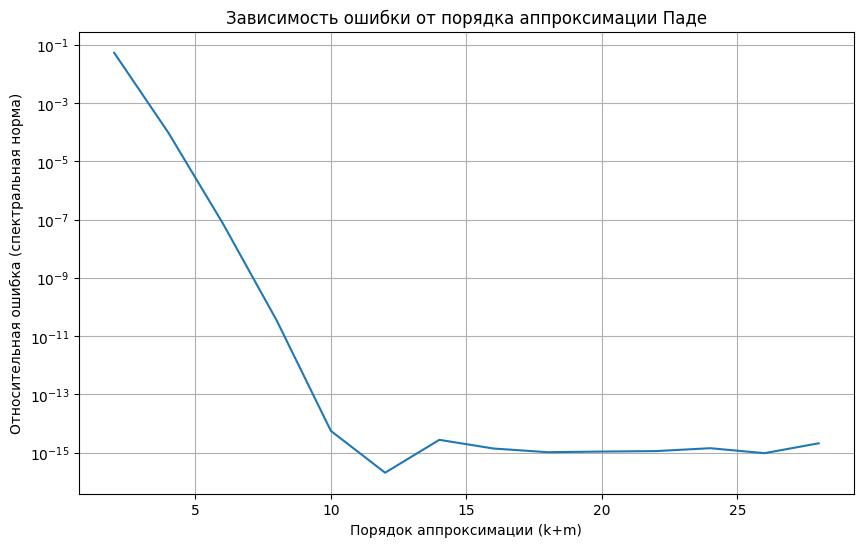

R:
[[ 51.9689562 +0.j  74.73656456+0.j]
 [112.10484685+0.j 164.07380304+0.j]]


In [63]:
A = np.array([[1, 2], [3, 4]])
s = 4

orders = range(1, 15); errors = []

for order in orders:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)

orders = range(2, 30, 2)

plt.figure(figsize=(10, 6))
plt.plot(orders, errors)
plt.xlabel("Порядок аппроксимации (k+m)")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки от порядка аппроксимации Паде")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

И ещё на 1 раз больше

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


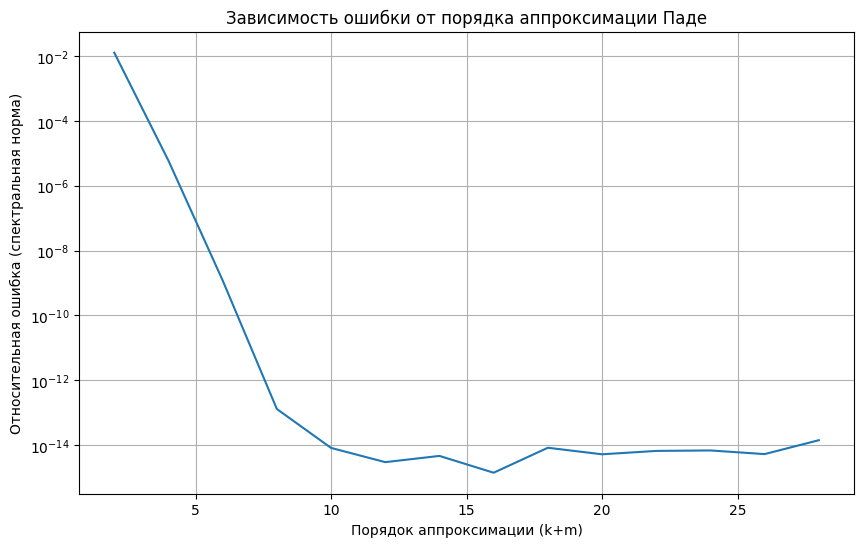

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [64]:
A = np.array([[1, 2], [3, 4]])
s = 5

orders = range(1, 15); errors = []

for order in orders:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)

orders = range(2, 30, 2)

plt.figure(figsize=(10, 6))
plt.plot(orders, errors)
plt.xlabel("Порядок аппроксимации (k+m)")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки от порядка аппроксимации Паде")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

Видимо, растет ошибка при возведении матрицы в квадрат.

Можно построить, например, зависимость ошибки для $R_{44}$ от $s$

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


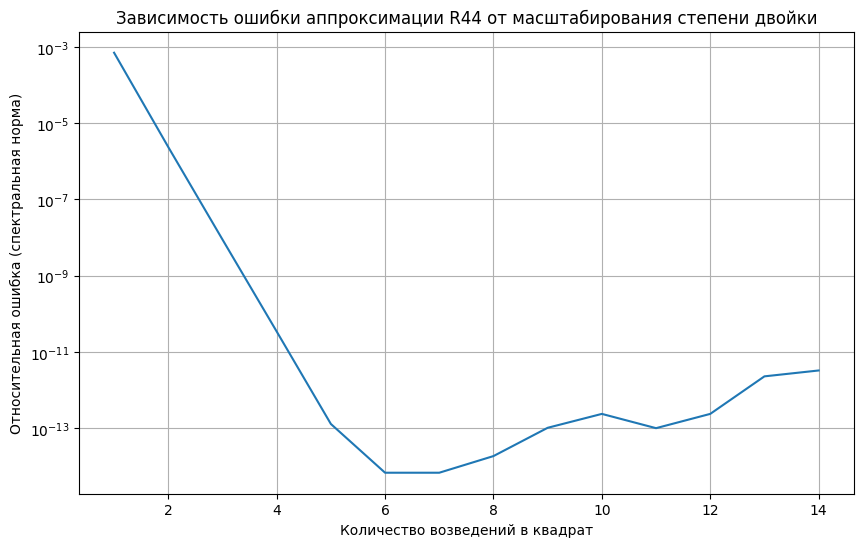

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [65]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 4

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R44 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


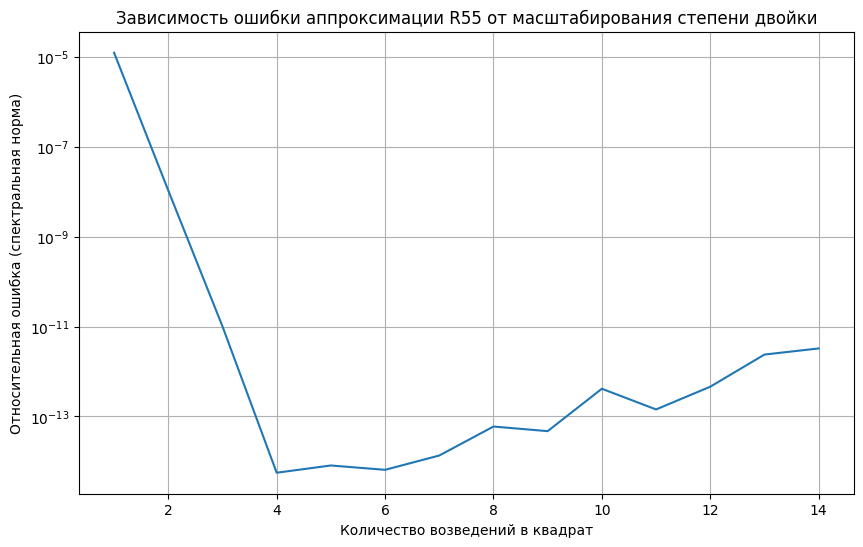

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [66]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 5

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R55 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


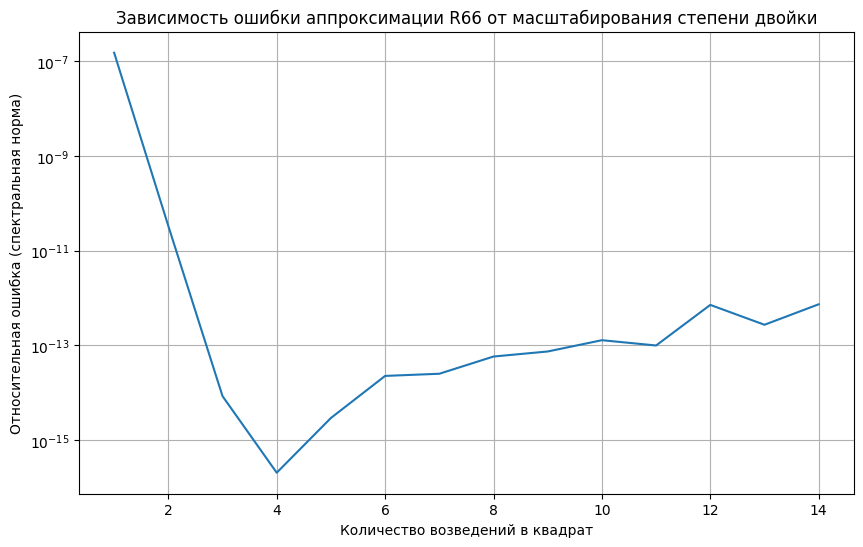

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [67]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 6

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R66 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


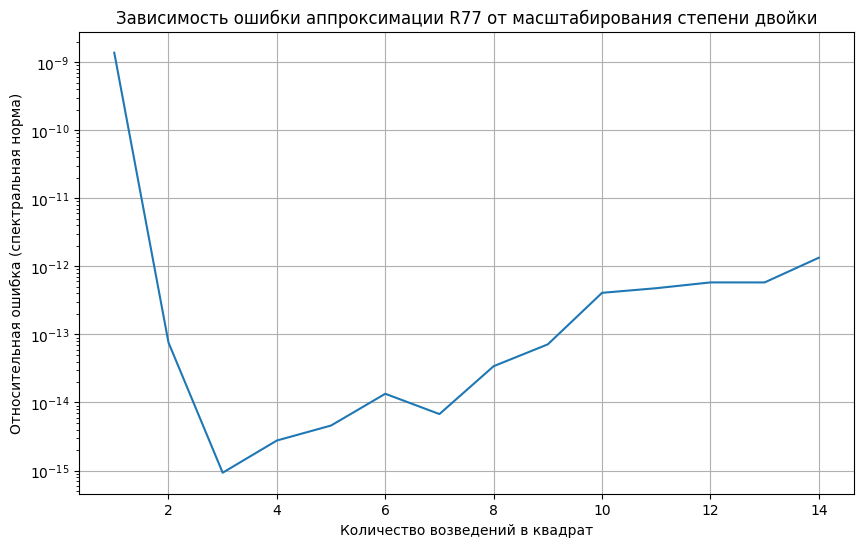

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [68]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 7

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R77 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


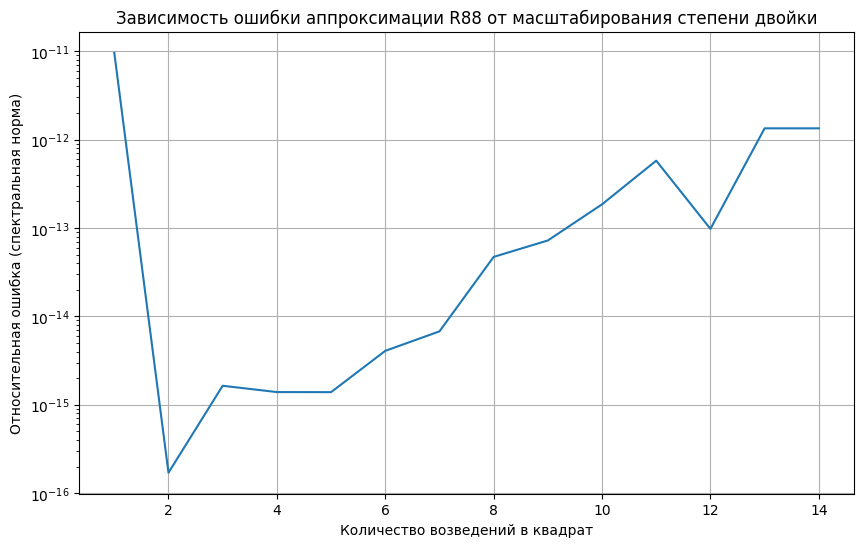

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [69]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 8

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R88 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


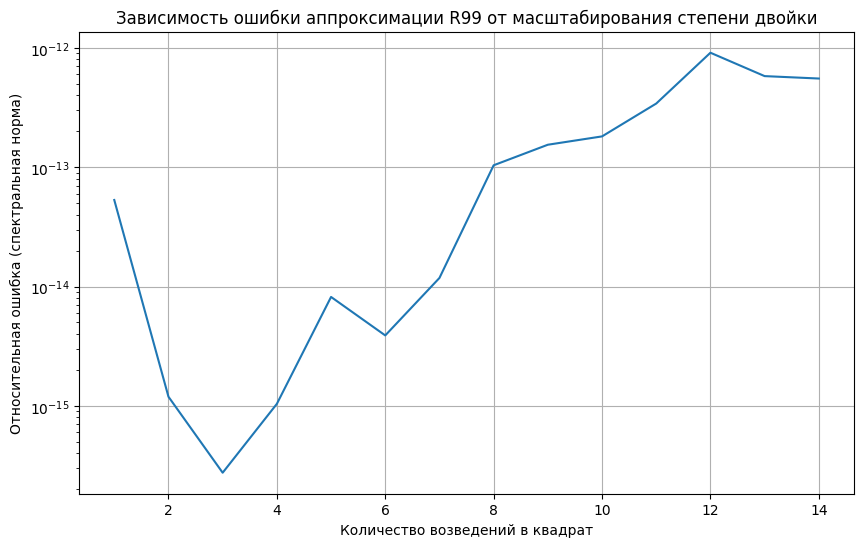

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [70]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 9

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R99 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


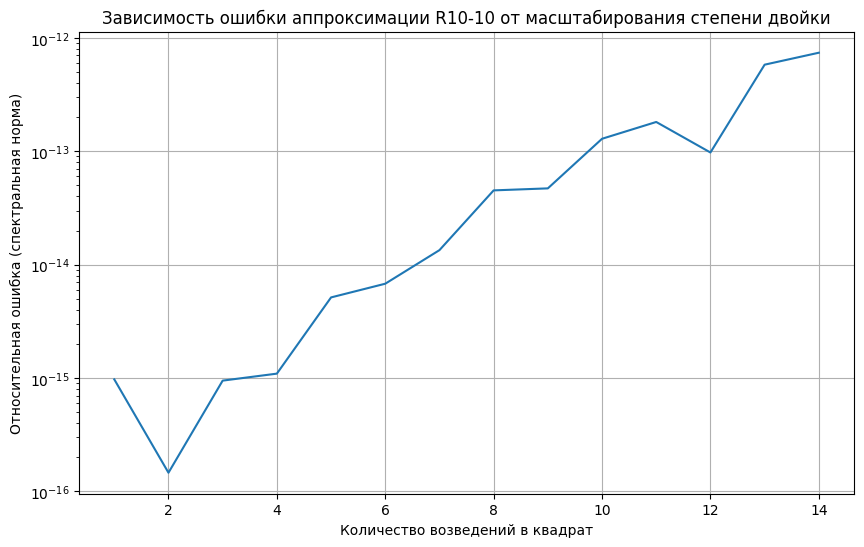

R:
[[ 51.9689562 +0.j  74.73656457+0.j]
 [112.10484685+0.j 164.07380305+0.j]]


In [71]:
A = np.array([[1, 2], [3, 4]])

stepeni = range(1, 15); errors = []

order = 10

for s in stepeni:
    approx_exp = matrix_exp_scaled_squared(A, s, order, order)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)



plt.figure(figsize=(10, 6))
plt.plot(stepeni, errors)
plt.xlabel("Количество возведений в квадрат")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации R10-10 от масштабирования степени двойки")
plt.grid(True)
plt.semilogy()
plt.show()

R = matrix_exp_scaled_squared(A,s,4,4); print(f"R:\n{R}")

Сравним скорость работы метода $R_{77}$ с маштабированием порядка 3, который дает машинную точность вычисления экспоненты, со скоростью работы встроенного алгоритма.

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


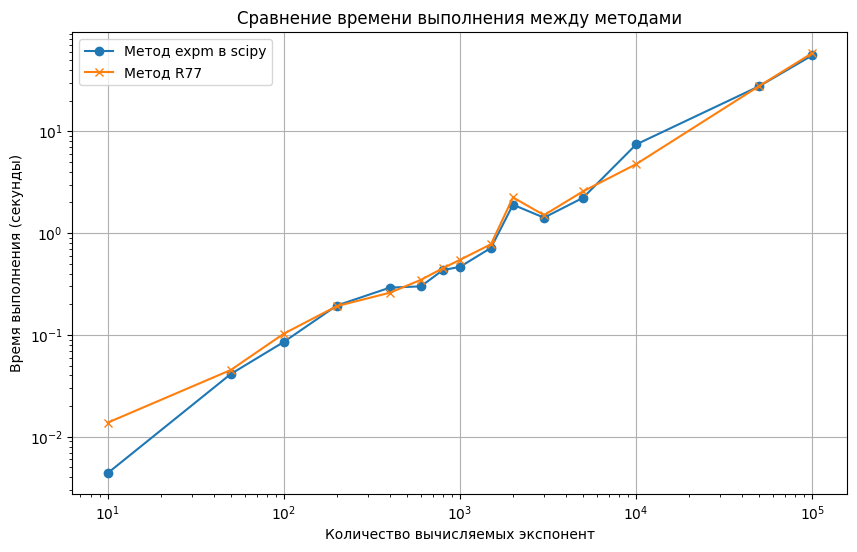

Количество экспонент: 10, Время выполнения (scipy): 0.004397 секунд, Время выполнения (R): 0.013771 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.041371 секунд, Время выполнения (R): 0.045296 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.085405 секунд, Время выполнения (R): 0.102998 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.194597 секунд, Время выполнения (R): 0.192031 секунд
Количество экспонент: 400, Время выполнения (scipy): 0.291656 секунд, Время выполнения (R): 0.260013 секунд
Количество экспонент: 600, Время выполнения (scipy): 0.300134 секунд, Время выполнения (R): 0.347605 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.434099 секунд, Время выполнения (R): 0.452543 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.466171 секунд, Время выполнения (R): 0.546821 секунд
Количество экспонент: 1500, Время выполнения (scipy): 0.716538 секунд, Время выполнения (R): 0.778227 секунд
Количество экспонент: 2000, 

In [72]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_scaled_squared(A, 3, 7, 7)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод R77')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

**Выводы.**

Итак, чтобы достичь машинной точности, достаточно использовать метод не меньше 14-го порядка аппроксимации и масштабировать матрицу до нормы порядка единицы. Большее масштабирование снижает точность.

Скорость сравнивается со встроенным методом в scipy, потому что scipy использует примерно такой же метод вычисления. Однако небольшое отставание связано с тем, что коэффициенты в методе $R_{77}$ каждый раз вычисляются заново. Если это оптимизировать, то время работы будет почти одинаковым.

##### Скорость вычисления экспонент с помощью определения экспоненты через предел

Можно вычислять экспоненту от матрицы размера $2 \times 2$, используя определение экспоненты через предел

$$
\lim _{s \rightarrow \infty}(I+A / s)^s ;  s = 2^N
$$

In [1]:
def true_matrix_exponential(A):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    eigvals, P = np.linalg.eig(A); D = np.diag(np.exp(eigvals))
    expA = P @ D @ np.linalg.inv(P)
    return expA

def lim_matrix_exponential(A, N):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    s = 2**N; I = np.eye(A.shape[0], dtype=A.dtype); expA = I + A / s

    for k in range(N):
        expA = matrix_squaring(expA)
    return expA

def matrix_squaring(A):
    if A.shape != (2, 2):
        raise ValueError("Input must be a 2x2 matrix")
    Asqr = np.array([[A[0][0]**2 + A[0][1]*A[1][0], A[0][1]*(A[0][0] + A[1][1])],
                     [A[1][0]*(A[0][0] + A[1][1]), A[1][1]**2 + A[0][1]*A[1][0]]])
    return Asqr

A = np.array([[1, 2], [3, 4]])
expA = true_matrix_exponential(A); U_diff, S_diff, Vt_diff = [], [], []

for i in range(1, 100):
    limexpA = lim_matrix_exponential(A, i)
    U, S, Vt = np.linalg.svd((expA - limexpA)/np.linalg.norm(expA, ord=2))
    U_diff.append(U); S_diff.append(S); Vt_diff.append(Vt)

U_diff = np.array(U_diff); S_diff = np.array(S_diff); Vt_diff = np.array(Vt_diff)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(S_diff.T[0])), S_diff.T[0], marker = 'o')
plt.title('Ошибка по спектральной норме для lim_exponential')
plt.xlabel('Количество шагов в lim_exponential')
plt.yscale('log')
plt.ylabel('Jтносительная ошибка при вычислении lim_exponential')
plt.grid(True); plt.show()

for i in range(0, 58, 3):
    print('Относительная ошибка по спектральной норме при s = ', i, 'равна ', S_diff.T[0][i])

NameError: name 'np' is not defined

Скачок ошибки связан с тем, что при делении матрицы на $2^{52}$ её элементы уменьшаются до уровня машинной погрешности.

Легко увидеть, что точность этого метода значительно уступает точности встроенного метода.  Можно сравнить их времена работы.


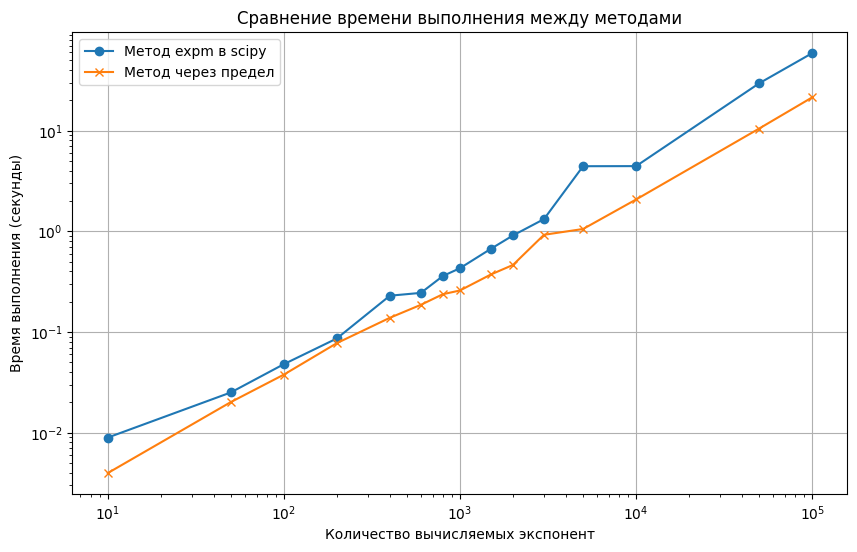

Количество экспонент: 10, Время выполнения (scipy): 0.008904 секунд, Время выполнения с помощью предела: 0.003951 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.025033 секунд, Время выполнения с помощью предела: 0.020080 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.047800 секунд, Время выполнения с помощью предела: 0.037635 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.086137 секунд, Время выполнения с помощью предела: 0.077394 секунд
Количество экспонент: 400, Время выполнения (scipy): 0.229113 секунд, Время выполнения с помощью предела: 0.138248 секунд
Количество экспонент: 600, Время выполнения (scipy): 0.244449 секунд, Время выполнения с помощью предела: 0.186027 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.359510 секунд, Время выполнения с помощью предела: 0.237133 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.429909 секунд, Время выполнения с помощью предела: 0.258198 секунд
Количество экспонент: 150

In [90]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        lim_matrix_exponential(A, 35)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через предел')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью предела: {t_R:.6f} секунд")

Можно  сравнить с методом аппроксимации Паде с масштабированием, подобрав его параметры таким образом, чтобы точность была той же самой.

<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


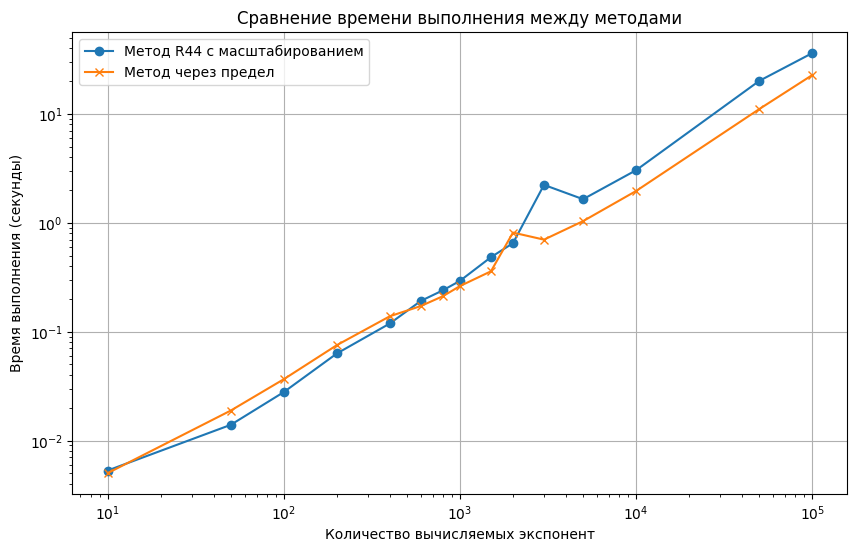

Количество экспонент: 10, Время выполнения (R44): 0.005301 секунд, Время выполнения с помощью предела: 0.005016 секунд
Количество экспонент: 50, Время выполнения (R44): 0.013937 секунд, Время выполнения с помощью предела: 0.018849 секунд
Количество экспонент: 100, Время выполнения (R44): 0.027855 секунд, Время выполнения с помощью предела: 0.036569 секунд
Количество экспонент: 200, Время выполнения (R44): 0.062979 секунд, Время выполнения с помощью предела: 0.075148 секунд
Количество экспонент: 400, Время выполнения (R44): 0.118843 секунд, Время выполнения с помощью предела: 0.138482 секунд
Количество экспонент: 600, Время выполнения (R44): 0.191573 секунд, Время выполнения с помощью предела: 0.171914 секунд
Количество экспонент: 800, Время выполнения (R44): 0.239590 секунд, Время выполнения с помощью предела: 0.211606 секунд
Количество экспонент: 1000, Время выполнения (R44): 0.292724 секунд, Время выполнения с помощью предела: 0.262070 секунд
Количество экспонент: 1500, Время выполне

In [91]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

s = 3

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      matrix_exp_scaled_squared(A,s,4,4)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        lim_matrix_exponential(A, 35)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод R44 с масштабированием')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через предел')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (R44): {t_scipy:.6f} секунд, Время выполнения с помощью предела: {t_R:.6f} секунд")

In [95]:
approx_exp = matrix_exp_scaled_squared(A, 3, 4, 4)
true_exp = expm(A)
error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
print(error)

8.863492426586206e-09


<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


In [96]:
approx_exp = lim_matrix_exponential(A, 35)
true_exp = expm(A)
error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
print(error)

3.95540724423537e-08


In [97]:
approx_exp = matrix_exp_scaled_squared(A, 3, 3, 3)
true_exp = expm(A)
error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
print(error)

4.974501773239633e-06


<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


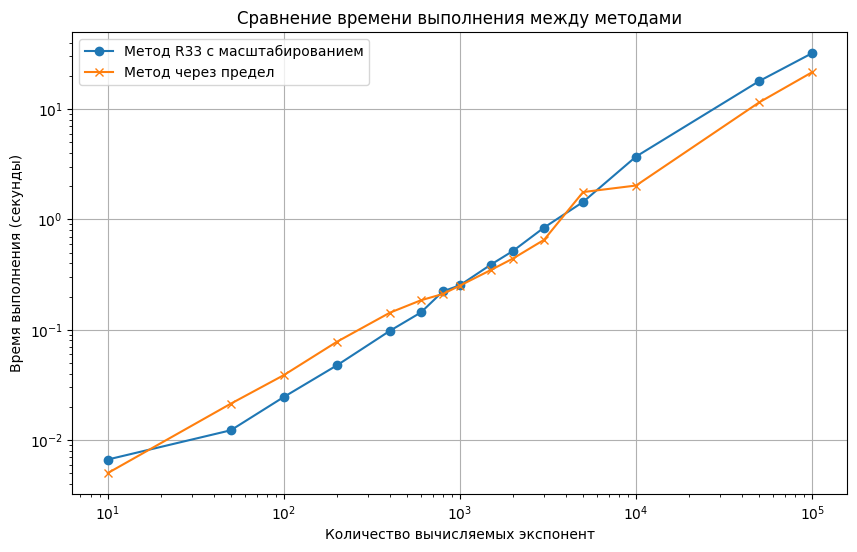

Количество экспонент: 10, Время выполнения (R44): 0.006666 секунд, Время выполнения с помощью предела: 0.005023 секунд
Количество экспонент: 50, Время выполнения (R44): 0.012282 секунд, Время выполнения с помощью предела: 0.021395 секунд
Количество экспонент: 100, Время выполнения (R44): 0.024604 секунд, Время выполнения с помощью предела: 0.038827 секунд
Количество экспонент: 200, Время выполнения (R44): 0.047572 секунд, Время выполнения с помощью предела: 0.077805 секунд
Количество экспонент: 400, Время выполнения (R44): 0.097833 секунд, Время выполнения с помощью предела: 0.142886 секунд
Количество экспонент: 600, Время выполнения (R44): 0.143547 секунд, Время выполнения с помощью предела: 0.185083 секунд
Количество экспонент: 800, Время выполнения (R44): 0.222841 секунд, Время выполнения с помощью предела: 0.211179 секунд
Количество экспонент: 1000, Время выполнения (R44): 0.253230 секунд, Время выполнения с помощью предела: 0.251461 секунд
Количество экспонент: 1500, Время выполне

In [98]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

s = 3

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      matrix_exp_scaled_squared(A,s,3,3)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        lim_matrix_exponential(A, 35)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод R33 с масштабированием')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через предел')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (R33): {t_scipy:.6f} секунд, Время выполнения с помощью предела: {t_R:.6f} секунд")

Получилось, что метод аппроксимации Паде восьмого порядка аппроксимации дает в 5 раз меньшую ошибку, но работает 1.5-2 раза медленнее. Метод аппроксимации Паде 6-го порядка дает ошибку в 100 раз больше и работает медленнее.

**Вывод.**

Судя по всему, метод вычисления экспоненты через предел может рассматриваться как альтернатива часто используемому в практических приложениях методу аппроксимаций Паде 8-го порядка с масштабированием. Он работает немного быстрее, но дает меньшую точность.

##### Скорость вычисления при расчете по формуле Тейлора напрямую.

Рассмотрим сначала наивный алгоритм.

In [99]:
def matrix_exponential_taylor_naivn(A, iterations):
    n = A.shape[0]
    result = np.eye(n, dtype=complex)
    term = np.eye(n, dtype=complex)
    for i in range(1, iterations + 1):
        term = np.dot(term, A) / i
        result += term
    return result

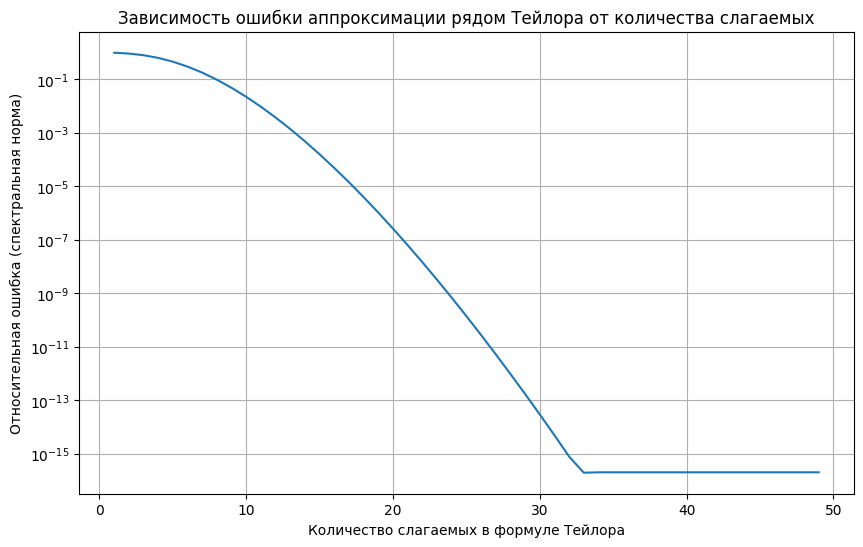

Относительная ошибка по спектральной норме при iteration =  1 равна  0.9704928195522368
Относительная ошибка по спектральной норме при iteration =  4 равна  0.6222961933938721
Относительная ошибка по спектральной норме при iteration =  7 равна  0.17504556849916159
Относительная ошибка по спектральной норме при iteration =  10 равна  0.02179692375631783
Относительная ошибка по спектральной норме при iteration =  13 равна  0.001361423463170399
Относительная ошибка по спектральной норме при iteration =  16 равна  4.7721015779301517e-05
Относительная ошибка по спектральной норме при iteration =  19 равна  1.0234848264432344e-06
Относительная ошибка по спектральной норме при iteration =  22 равна  1.4345699192889271e-08
Относительная ошибка по спектральной норме при iteration =  25 равна  1.3830221130418786e-10
Относительная ошибка по спектральной норме при iteration =  28 равна  9.551503592137815e-13
Относительная ошибка по спектральной норме при iteration =  31 равна  4.894516646356223e-1

In [103]:
A = np.array([[1, 2], [3, 4]])

iterations = range(1, 50); errors = []

for iteration in iterations:
    approx_exp = matrix_exponential_taylor_naivn(A, iteration)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)


plt.figure(figsize=(10, 6))
plt.plot(iterations, errors)
plt.xlabel("Количество слагаемых в формуле Тейлора")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации рядом Тейлора от количества слагаемых")
plt.grid(True)
plt.semilogy()
plt.show()

# Вывод результатов
for i in range(1, 49, 3):
    print('Относительная ошибка по спектральной норме при iteration = ', i, 'равна ', errors[i-1])

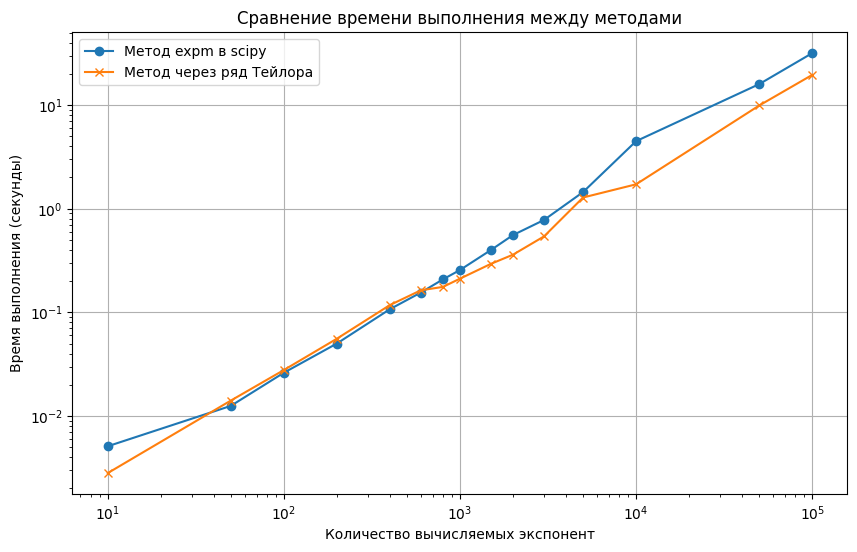

Количество экспонент: 10, Время выполнения (scipy): 0.005104 секунд, Время выполнения с помощью ряда Тейлора 0.002812 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.012517 секунд, Время выполнения с помощью ряда Тейлора 0.014084 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.026132 секунд, Время выполнения с помощью ряда Тейлора 0.027743 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.050006 секунд, Время выполнения с помощью ряда Тейлора 0.055655 секунд
Количество экспонент: 400, Время выполнения (scipy): 0.107199 секунд, Время выполнения с помощью ряда Тейлора 0.117514 секунд
Количество экспонент: 600, Время выполнения (scipy): 0.155304 секунд, Время выполнения с помощью ряда Тейлора 0.163220 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.207832 секунд, Время выполнения с помощью ряда Тейлора 0.175864 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.255956 секунд, Время выполнения с помощью ряда Тейлора 0.211213 

In [108]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exponential_taylor_naivn(A, 34)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через ряд Тейлора')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью ряда Тейлора {t_R:.6f} секунд")

Как видим, метод Тейлора оказался эффективнее. Но дело в том, что он быстро сходится из-за того, что матрица маленькой нормы. Если матрица будет большой нормы, то придется использовать дополнительные ухищрения. Например, масштабирование.

s =  3


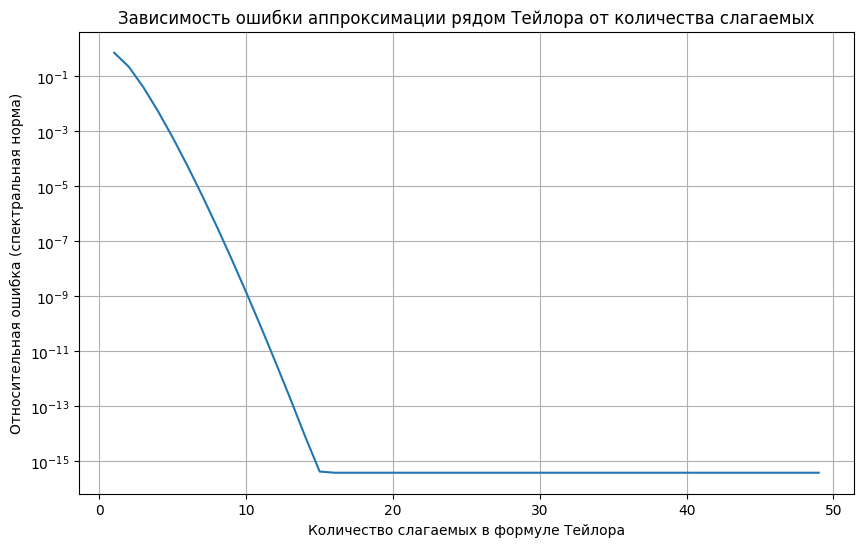

Относительная ошибка по спектральной норме при iteration =  1 равна  0.7170758474920856
Относительная ошибка по спектральной норме при iteration =  2 равна  0.22124252775094724
Относительная ошибка по спектральной норме при iteration =  3 равна  0.039176738081718045
Относительная ошибка по спектральной норме при iteration =  4 равна  0.00521531832724537
Относительная ошибка по спектральной норме при iteration =  5 равна  0.0005750087492220366
Относительная ошибка по спектральной норме при iteration =  6 равна  5.447707224011701e-05
Относительная ошибка по спектральной норме при iteration =  7 равна  4.528130266638173e-06
Относительная ошибка по спектральной норме при iteration =  8 равна  3.35222081098785e-07
Относительная ошибка по спектральной норме при iteration =  9 равна  2.2367542639841825e-08
Относительная ошибка по спектральной норме при iteration =  10 равна  1.358257601105845e-09
Относительная ошибка по спектральной норме при iteration =  11 равна  7.566882734877472e-11
Относ

In [112]:
def matrix_exp_scaled_squared_for_taylor(A, s, iterations):

    scaled_A = A / (2**s)
    R = matrix_exponential_taylor_naivn(scaled_A, iterations)

    for _ in range(s):
        R = np.dot(R, R)

    return R

A = np.array([[1, 2], [3, 4]])

iterations = range(1, 50); errors = []

s = int(np.log2(np.linalg.norm(A, ord=2)))+1

print('s = ', s)

for iteration in iterations:
    approx_exp = matrix_exp_scaled_squared_for_taylor(A, s, iteration)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)


plt.figure(figsize=(10, 6))
plt.plot(iterations, errors)
plt.xlabel("Количество слагаемых в формуле Тейлора")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации рядом Тейлора от количества слагаемых")
plt.grid(True)
plt.semilogy()
plt.show()

# Вывод результатов
for i in range(1, 49, 1):
    print('Относительная ошибка по спектральной норме при iteration = ', i, 'равна ', errors[i-1])

Масштабирование позволяет уменьшить требуемое количество слагаемых приблизительно до 15, и работает на матрице с любой нормой. Проверим, как это повлияет на скорость работы.

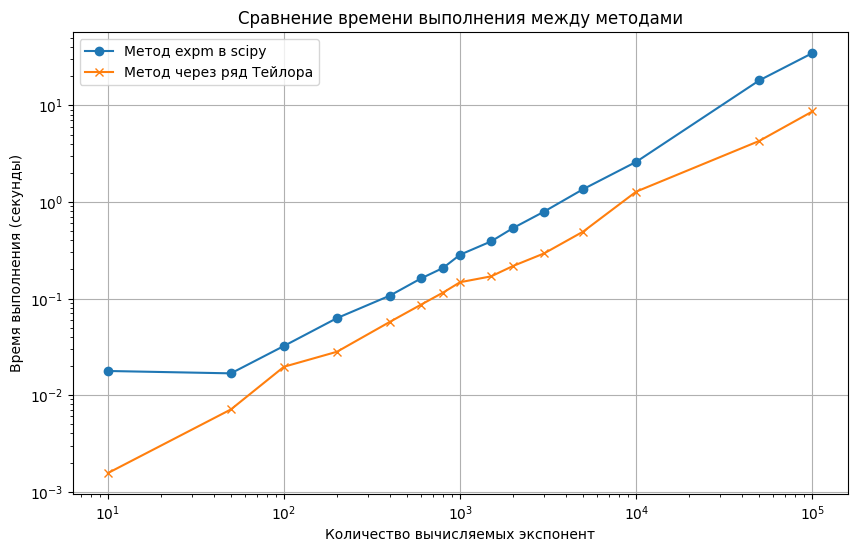

Количество экспонент: 10, Время выполнения (scipy): 0.017768 секунд, Время выполнения с помощью ряда Тейлора 0.001554 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.016791 секунд, Время выполнения с помощью ряда Тейлора 0.007105 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.032269 секунд, Время выполнения с помощью ряда Тейлора 0.019645 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.062691 секунд, Время выполнения с помощью ряда Тейлора 0.028105 секунд
Количество экспонент: 400, Время выполнения (scipy): 0.107361 секунд, Время выполнения с помощью ряда Тейлора 0.057436 секунд
Количество экспонент: 600, Время выполнения (scipy): 0.161536 секунд, Время выполнения с помощью ряда Тейлора 0.086421 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.207433 секунд, Время выполнения с помощью ряда Тейлора 0.115229 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.284527 секунд, Время выполнения с помощью ряда Тейлора 0.147675 

In [113]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_scaled_squared_for_taylor(A, 3, 15)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через ряд Тейлора')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью ряда Тейлора {t_R:.6f} секунд")

Ряд Тейлора без потери точности работает в несколько раз быстрее встроенного методы. Видимо, это связано с его эффективностью для матриц малого размера. Эта гипотеза полностью подтверждается вычислениями.

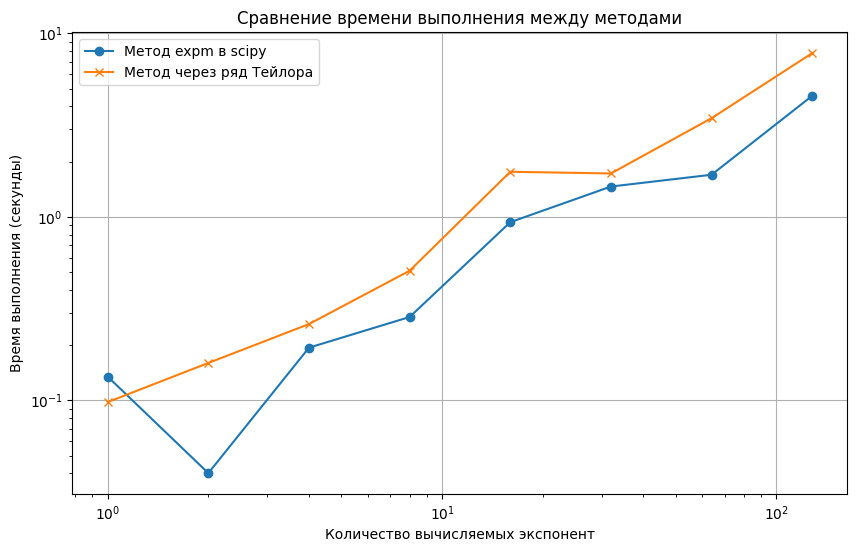

Количество экспонент: 1, Время выполнения (scipy): 0.134594 секунд, Время выполнения с помощью ряда Тейлора 0.097766 секунд
Количество экспонент: 2, Время выполнения (scipy): 0.040109 секунд, Время выполнения с помощью ряда Тейлора 0.159794 секунд
Количество экспонент: 4, Время выполнения (scipy): 0.193590 секунд, Время выполнения с помощью ряда Тейлора 0.260302 секунд
Количество экспонент: 8, Время выполнения (scipy): 0.284451 секунд, Время выполнения с помощью ряда Тейлора 0.508437 секунд
Количество экспонент: 16, Время выполнения (scipy): 0.934830 секунд, Время выполнения с помощью ряда Тейлора 1.759915 секунд
Количество экспонент: 32, Время выполнения (scipy): 1.461821 секунд, Время выполнения с помощью ряда Тейлора 1.722477 секунд
Количество экспонент: 64, Время выполнения (scipy): 1.695264 секунд, Время выполнения с помощью ряда Тейлора 3.447835 секунд
Количество экспонент: 128, Время выполнения (scipy): 4.565102 секунд, Время выполнения с помощью ряда Тейлора 7.797794 секунд


In [115]:
A = np.random.rand(200, 200)

num_exponents = [1, 2, 4, 8, 16, 32, 64, 128] # 50] #, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

s = int(np.log2(np.linalg.norm(A, ord=2)))+1

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_scaled_squared_for_taylor(A, s, 15)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через ряд Тейлора')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью ряда Тейлора {t_R:.6f} секунд")

##### Скорость вычисления при расчете по формуле Тейлора с использованием теоремы Гамильтона-Кэли

Используя теорему Гамильтона-Кэли, можно значительно увеличить скорость вычисления степеней матрицы в ряде Тейлора.

In [119]:
def matrix_exponent_taylor_gamilton(A, num_iterations=15):
    """Вычисляет экспоненту матрицы 2x2 с помощью ряда Тейлора и теоремы Гамильтона-Кэли."""
    I = np.eye(2)
    n = A.shape[0]

    # Характеристический полином: p(λ) = λ^2 - tr(A)λ + det(A)
    trace_A = np.trace(A)
    det_A = np.linalg.det(A)

    # Теорема Гамильтона-Кэли: A^2 - tr(A)A + det(A)I = 0
    # A^2 = tr(A)A - det(A)I

    result = I + A
    A_power = A.copy()
    A_prev = I

    for k in range(2, num_iterations):
        A_power, A_prev = trace_A * A_power - det_A * A_prev, A_power  # Используем предыдущую степень
        result += (1 / math.factorial(k)) * A_power

    return result

def matrix_exp_scaled_squared_for_taylor_gamilton(A, s, iterations = 15):

    scaled_A = A / (2**s)
    R = matrix_exponential_taylor_naivn(scaled_A, iterations)

    for _ in range(s):
        R = np.dot(R, R)

    return R

s =  3


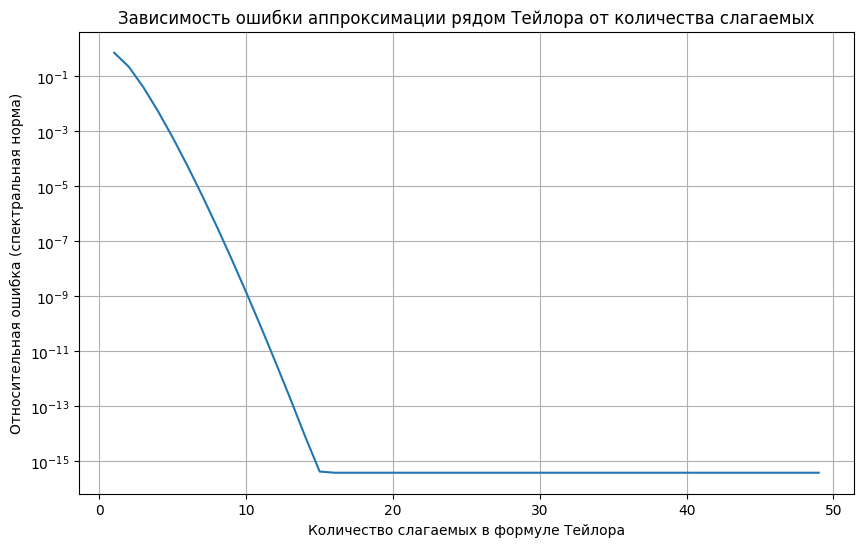

Относительная ошибка по спектральной норме при iteration =  1 равна  0.7170758474920856
Относительная ошибка по спектральной норме при iteration =  2 равна  0.22124252775094724
Относительная ошибка по спектральной норме при iteration =  3 равна  0.039176738081718045
Относительная ошибка по спектральной норме при iteration =  4 равна  0.00521531832724537
Относительная ошибка по спектральной норме при iteration =  5 равна  0.0005750087492220366
Относительная ошибка по спектральной норме при iteration =  6 равна  5.447707224011701e-05
Относительная ошибка по спектральной норме при iteration =  7 равна  4.528130266638173e-06
Относительная ошибка по спектральной норме при iteration =  8 равна  3.35222081098785e-07
Относительная ошибка по спектральной норме при iteration =  9 равна  2.2367542639841825e-08
Относительная ошибка по спектральной норме при iteration =  10 равна  1.358257601105845e-09
Относительная ошибка по спектральной норме при iteration =  11 равна  7.566882734877472e-11
Относ

In [122]:
A = np.array([[1, 2], [3, 4]])

iterations = range(1, 50); errors = []

s = int(np.log2(np.linalg.norm(A, ord=2)))+1

print('s = ', s)

for iteration in iterations:
    approx_exp = matrix_exp_scaled_squared_for_taylor_gamilton(A, s, iteration)
    true_exp = expm(A)
    error = np.linalg.norm(approx_exp - true_exp, ord=2)/np.linalg.norm(true_exp, ord=2)
    errors.append(error)


plt.figure(figsize=(10, 6))
plt.plot(iterations, errors)
plt.xlabel("Количество слагаемых в формуле Тейлора")
plt.ylabel("Относительная ошибка (спектральная норма)")
plt.title("Зависимость ошибки аппроксимации рядом Тейлора от количества слагаемых")
plt.grid(True)
plt.semilogy()
plt.show()

# Вывод результатов
for i in range(1, 49, 1):
    print('Относительная ошибка по спектральной норме при iteration = ', i, 'равна ', errors[i-1])

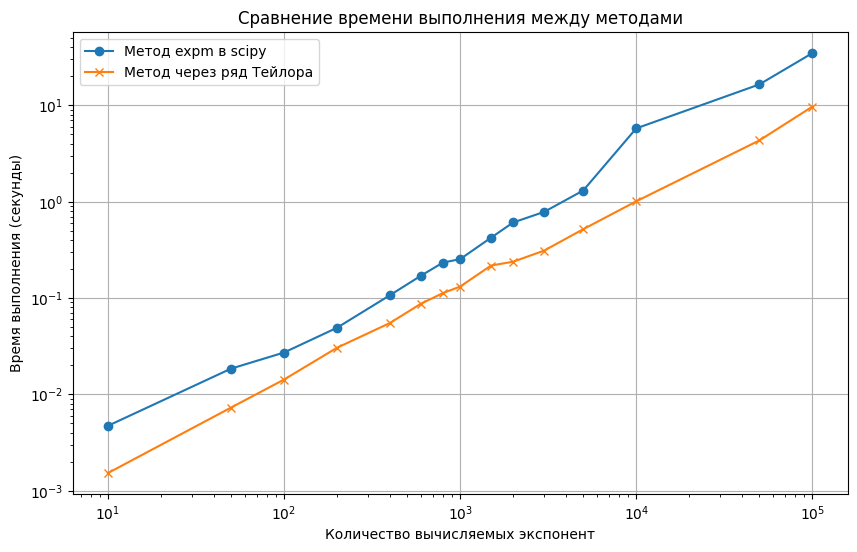

Количество экспонент: 10, Время выполнения (scipy): 0.004706 секунд, Время выполнения с помощью ряда Тейлора 0.001521 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.018475 секунд, Время выполнения с помощью ряда Тейлора 0.007278 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.027164 секунд, Время выполнения с помощью ряда Тейлора 0.014225 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.049112 секунд, Время выполнения с помощью ряда Тейлора 0.030454 секунд
Количество экспонент: 400, Время выполнения (scipy): 0.107092 секунд, Время выполнения с помощью ряда Тейлора 0.055087 секунд
Количество экспонент: 600, Время выполнения (scipy): 0.170816 секунд, Время выполнения с помощью ряда Тейлора 0.087365 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.233567 секунд, Время выполнения с помощью ряда Тейлора 0.112638 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.253330 секунд, Время выполнения с помощью ряда Тейлора 0.131421 

In [123]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_scaled_squared_for_taylor_gamilton(A, 3, 15)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через ряд Тейлора')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью ряда Тейлора {t_R:.6f} секунд")

**Вывод**.

Для матриц малого размера вычисление через формулу Тейлора с использованием масштабирования предпочтительнее. В данном случае выигрыш во времени примерно в 3-4 раза без потери точности.

##### Вычисление экспоненты матрицы по явной формуле

Экспоненту можно вычислять следующим образом:

$$
e^{A \cdot q}=e^{u \cdot q} \cdot\left(\cosh (r \cdot q) \cdot \mathbf{I}+\frac{\sinh (r \cdot q)}{r}\left(v \cdot \mathbf{e}_1+w \cdot \mathbf{e}_2+t \cdot \mathbf{e}_{12}\right)\right)
$$

$$
\begin{gathered}
r=\sqrt{w^2+v^2-t^2} ; \quad u=\frac{a+d}{2}, \quad v=\frac{a-d}{2}, \quad w=\frac{b+c}{2}, \quad t=\frac{b-c}{2} \\
\left(\begin{array}{cc}
a & b \\
c & d
\end{array}\right)=u \cdot \mathbf{I}+v \cdot \mathbf{e}_1+w \cdot \mathbf{e}_2+t \cdot \mathbf{e}_{12} \\
\mathbf{e}_1=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right), \quad \mathbf{e}_2=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \mathbf{e}_{12}=\left(\begin{array}{cc}
0 & 1 \\
-1 & 0
\end{array}\right)
\end{gathered}
$$

В случае $r=0$ можно использовать более простую формулу

$$
e^A=e^{(a+d / 2)}\left(\begin{array}{cc}
1+\frac{a-d}{2} & b \\
c & 1-\frac{a-d}{2}
\end{array}\right) .
$$


Отдельно интересен случай, в котором $r$ очень мало, а $r \cdot q$ не мало.

Кроме того, чтобы упростить вычисления, можно отдельно рассматривать случай чисто мнимого значения $r$ и вещественного. Если $r$ - мнимое число, то гиперболические функции нужно заменить на обычные косинус и синус.

Важным преимуществом этой формулы является то, что она единым образом вычисляет экспоненты любых матриц, в том числе комплексных. Кроме того, она может быть переписана следующим образом

$$
f(A)=\frac{f\left(\lambda_{+}\right)+f\left(\lambda_{-}\right)}{2} I+\frac{A-\left(\frac{\operatorname{tr}(A)}{2}\right) I}{\sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|}} \frac{f\left(\lambda_{+}\right)-f\left(\lambda_{-}\right)}{2}
$$


где $f(x)=e^x$

In [7]:
def matrix_exp_analytic(A, q = 1):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r2 = (u*u - det_A) ;
    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    if r2 > 10**(-15):
      r = r2**0.5
      p1 = np.cosh(r*q)
      p2 = np.sinh(r*q)/r
      result = (p1*I + p2*(A - u*I))*math.exp(u*q)
      return result

    if r2 < -10**(-15):
      r = abs(r2)**0.5
      p1 = np.cos(r*q)
      p2 = np.sin(r*q)/r
      result = (p1*I + p2*(A - u*I))*math.exp(u*q)
      return result

    result = math.exp(u*q)*(I + q*(A - u*I))
    return result


def test_matrix_exps():
    num_tests = 100 # Количество тестов
    flag = False
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        det_A = np.linalg.det(A)
        result = matrix_exp_analytic(A)
        expected_result = expm(A)
        error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
        flag = (error > 10**(-14))
        # Вывод результатов
        if flag:
          print(f"Матрица A:\n{A}\nСтепень n: {n}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
          if error > 0.1:
            print(det_A)
    return -1

# Запуск тестирования
test_matrix_exps()

-1

In [217]:
A = np.array([[1, 2], [3, 4]])
result = matrix_exp_analytic(A)
expected_result = expm(A)
error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
print(error)

1.592574869214689e-16


Формула работает очень точно, даже лучше формулы Тейлора.

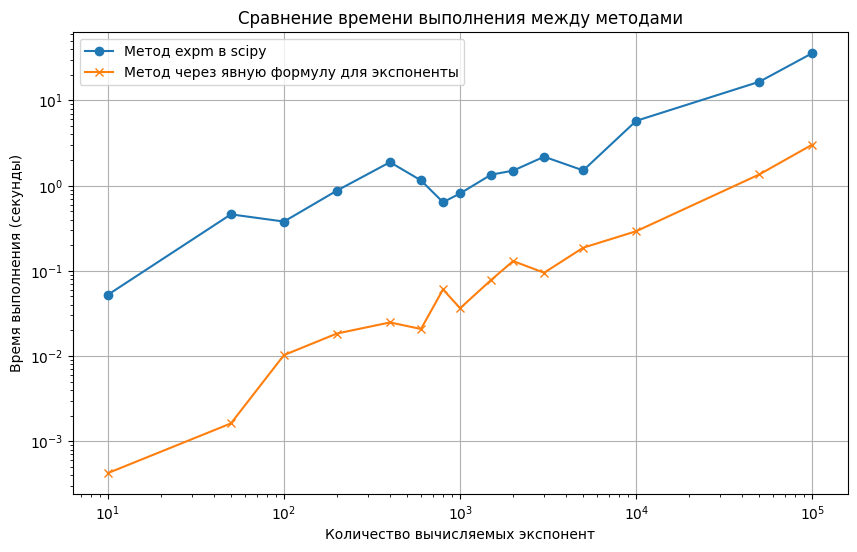

Количество экспонент: 10, Время выполнения (scipy): 0.052299 секунд, Время выполнения с помощью аналитической формулы 0.000423 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.460040 секунд, Время выполнения с помощью аналитической формулы 0.001621 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.378454 секунд, Время выполнения с помощью аналитической формулы 0.010266 секунд
Количество экспонент: 200, Время выполнения (scipy): 0.874145 секунд, Время выполнения с помощью аналитической формулы 0.018394 секунд
Количество экспонент: 400, Время выполнения (scipy): 1.883096 секунд, Время выполнения с помощью аналитической формулы 0.024811 секунд
Количество экспонент: 600, Время выполнения (scipy): 1.150564 секунд, Время выполнения с помощью аналитической формулы 0.020786 секунд
Количество экспонент: 800, Время выполнения (scipy): 0.638249 секунд, Время выполнения с помощью аналитической формулы 0.060506 секунд
Количество экспонент: 1000, Время выполнения (scipy): 0.8

In [219]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_analytic(A)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через явную формулу для экспоненты')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью аналитической формулы {t_R:.6f} секунд")

##### Общее сравнение всех использованных методов для экспоненты


<ipython-input-62-f8a1f28202d6>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P += (np.math.factorial(k + m - j) * np.math.factorial(k) / (np.math.factorial(k + m) * np.math.factorial(k - j) * np.math.factorial(j))) * H
<ipython-input-62-f8a1f28202d6>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Q += signum*(np.math.factorial(k + m - j) * np.math.factorial(m) / (np.math.factorial(k + m) * np.math.factorial(m - j) * np.math.factorial(j))) * H


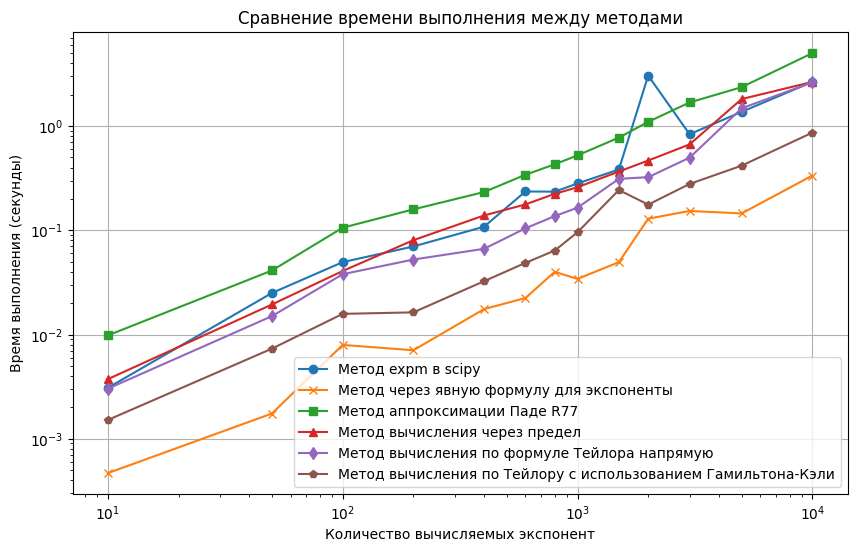

Количество экспонент: 10, Время выполнения (scipy): 0.003076 секунд, Время выполнения с помощью аналитической формулы: 0.000467 секунд, Время выполнения методом аппроксимации Паде R77: 0.009802 секунд, Метод вычисления через предел: 0.003727 секунд, Время выполнения методом вычисления по формуле Тейлора напрямую: 0.003018 секунд, Время выполнения методом вычисления по формуле Тейлора с использованием Гамильтона-Кэли: 0.001513 секунд
Количество экспонент: 50, Время выполнения (scipy): 0.025044 секунд, Время выполнения с помощью аналитической формулы: 0.001745 секунд, Время выполнения методом аппроксимации Паде R77: 0.041151 секунд, Метод вычисления через предел: 0.019422 секунд, Время выполнения методом вычисления по формуле Тейлора напрямую: 0.015016 секунд, Время выполнения методом вычисления по формуле Тейлора с использованием Гамильтона-Кэли: 0.007318 секунд
Количество экспонент: 100, Время выполнения (scipy): 0.049496 секунд, Время выполнения с помощью аналитической формулы: 0.0079

In [220]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000] # 50000, 100000]
execution_times = []
execution_times_R = []
execution_times_R1 = []
execution_times_R2 = []
execution_times_R3 = []
execution_times_R4 = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      expm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_exp_analytic(A)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

    # Временные замеры для метода R1 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R1
        matrix_exp_scaled_squared(A, 3, 7, 7)
    end_time = time.time()
    execution_times_R1.append(end_time - start_time)

    # Временные замеры для метода R2 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R2
        lim_matrix_exponential(A, 35)
    end_time = time.time()
    execution_times_R2.append(end_time - start_time)

    # Временные замеры для метода R3 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R3
        matrix_exponential_taylor_naivn(A, 35)
    end_time = time.time()
    execution_times_R3.append(end_time - start_time)

    # Временные замеры для метода R4 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R4
        matrix_exp_scaled_squared_for_taylor_gamilton(A, 3, 15)
    end_time = time.time()
    execution_times_R4.append(end_time - start_time)


plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод expm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через явную формулу для экспоненты')
plt.plot(num_exponents, execution_times_R1, marker='s', label='Метод аппроксимации Паде R77')
plt.plot(num_exponents, execution_times_R2, marker='^', label='Метод вычисления через предел')
plt.plot(num_exponents, execution_times_R3, marker='d', label='Метод вычисления по формуле Тейлора напрямую')
plt.plot(num_exponents, execution_times_R4, marker='p', label='Метод вычисления по Тейлору с использованием Гамильтона-Кэли')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R, t_R1, t_R2, t_R3, t_R4 in zip(num_exponents, execution_times, execution_times_R, execution_times_R1, execution_times_R2, execution_times_R3, execution_times_R4):
    print(f"Количество экспонент: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, "
          f"Время выполнения с помощью аналитической формулы: {t_R:.6f} секунд, "
          f"Время выполнения методом аппроксимации Паде R77: {t_R1:.6f} секунд, "
          f"Метод вычисления через предел: {t_R2:.6f} секунд, "
          f"Время выполнения методом вычисления по формуле Тейлора напрямую: {t_R3:.6f} секунд, "
          f"Время выполнения методом вычисления по формуле Тейлора с использованием Гамильтона-Кэли: {t_R4:.6f} секунд")

В этом сравнении следует отметить, что вычисление через предел имеет на несколько порядков ниже точность, чем все остальные
.

#### Матричный логарифм и его использование.

##### Вычисление матричного логарифма по явной формуле.



$$
\ln (A)=\frac{1}{2}\left(\ln (\operatorname{det} A) \cdot I+\frac{s}{r}\left(\begin{array}{cc}
v & w+t \\
w-t & -v
\end{array}\right)\right) ; \quad s=\ln \left(\frac{u+r}{u-r}\right)
$$

$$
\begin{gathered}
r=\sqrt{w^2+v^2-t^2} ; \quad u=\frac{a+d}{2}, \quad v=\frac{a-d}{2}, \quad w=\frac{b+c}{2}, \quad t=\frac{b-c}{2} \\
\left(\begin{array}{cc}
a & b \\
c & d
\end{array}\right)=u \cdot \mathbf{I}+v \cdot \mathbf{e}_1+w \cdot \mathbf{e}_2+t \cdot \mathbf{e}_{12} \\
\mathbf{e}_1=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right), \quad \mathbf{e}_2=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \mathbf{e}_{12}=\left(\begin{array}{cc}
0 & 1 \\
-1 & 0
\end{array}\right)
\end{gathered}
$$

Важным преимуществом этой формулы является то, что она единым образом вычисляет логарифмы любых матриц, в том числе комплексных. Кроме того, она может быть переписана следующим образом

$$
f(A)=\frac{f\left(\lambda_{+}\right)+f\left(\lambda_{-}\right)}{2} I+\frac{A-\left(\frac{\operatorname{tr}(A)}{2}\right) I}{\sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|}} \frac{f\left(\lambda_{+}\right)-f\left(\lambda_{-}\right)}{2}
$$


где $f(x)=\ln(x)$

 Комплексная матрица имеет логарифм тогда и только тогда, когда она является невырожденной. Кроме того, если определитель вещественной матрицы отрицателен, то она не имеет действительного логарифма.

В случае, если $r → 0$, можно записать упрощенную формулу

$$
\ln (A)=\frac{1}{2}\left(\ln (\operatorname{det} A) \cdot I+\frac{1}{u}\left(\begin{array}{cc}
v & w+t \\
w-t & -v
\end{array}\right)\right)
$$

In [239]:
A = np.array([[1, 2], [3, 4]])
print(np.linalg.norm(logm(expm(A))-A, 'fro')/np.linalg.norm(A, 'fro'))
print(np.linalg.norm(matrix_log_analytic(expm(A))-A, 'fro')/np.linalg.norm(A, 'fro'))
B = expm(A)
result = matrix_log_analytic(B)
expected_result = logm(B)
error = np.linalg.norm(result - expected_result, 'fro')/np.linalg.norm(expected_result, 'fro')
print(error)


3.783890250755347e-15
3.3674731643402955e-16
3.5686374484754955e-15


In [4]:
def matrix_log_analytic(A):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    u = 0.5*trace_A
    r2 = (u*u - det_A) ;
    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    if abs(r2) > 10**(-14):
      r = r2**0.5
      s = np.log((u+r)/(u-r))
      p1 = np.log(det_A)
      p2 = s/r
      result = (p1*I + p2*(A - u*I))*0.5
      return result

    result = 0.5*(I*np.log(det_A) + (2/u)*(A - u*I))
    return result


def test_matrix_logs():
    num_tests = 10 # Количество тестов
    flag = False
    mxerror = -1
    for _ in range(num_tests):
        # Генерация случайной матрицы 2x2
        A = np.random.randint(-10, 10, (2, 2))
        B = expm(A)
        det_A = np.linalg.det(A)
        result = matrix_log_analytic(B)
        expected_result = logm(B)
        error = np.linalg.norm(A - result, 'fro')/np.linalg.norm(A, 'fro')
        flag = (error > 10**(-9))
        mxerror = max(mxerror, error)

        # Вывод результатов
        if flag:
          print(f"Матрица A:\n{A}\nРезультат:\n{result}\nОжидаемый результат:\n{expected_result}\nОшибка по норме Фробениуса: {error}\n")
          if error > 0.1:
            print(det_A)
    print('максимальная относительная ошибка была равна ', mxerror)
    return -1

# Запуск тестирования
test_matrix_logs()

Матрица A:
[[ 4 -9]
 [-8 -8]]
Результат:
[[ 4.00000001 -9.00000001]
 [-8.00000001 -8.00000001]]
Ожидаемый результат:
[[ 4.00000001 -8.99999999]
 [-7.99999999 -7.99999998]]
Ошибка по норме Фробениуса: 1.1548611725715022e-09

максимальная относительная ошибка была равна  1.1548611725715022e-09


<ipython-input-4-13509f57cf37>:13: RuntimeWarning: invalid value encountered in scalar power
  r = r2**0.5


-1

Встроенная реализация не считает логарифмы для многих матриц, для которых успешно можно посчитать по аналитической формуле

<ipython-input-249-c801f2e6c9e4>:14: RuntimeWarning: invalid value encountered in log
  s = np.log((u+r)/(u-r))
<ipython-input-249-c801f2e6c9e4>:15: RuntimeWarning: invalid value encountered in log
  p1 = np.log(det_A)


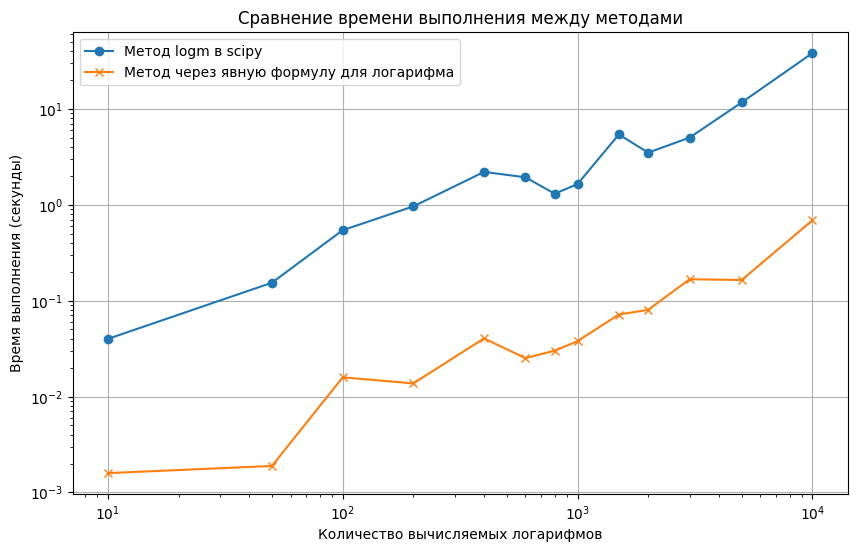

Количество логарифмов: 10, Время выполнения (scipy): 0.039851 секунд, Время выполнения с помощью аналитической формулы 0.001590 секунд
Количество логарифмов: 50, Время выполнения (scipy): 0.153577 секунд, Время выполнения с помощью аналитической формулы 0.001888 секунд
Количество логарифмов: 100, Время выполнения (scipy): 0.541420 секунд, Время выполнения с помощью аналитической формулы 0.015835 секунд
Количество логарифмов: 200, Время выполнения (scipy): 0.959634 секунд, Время выполнения с помощью аналитической формулы 0.013700 секунд
Количество логарифмов: 400, Время выполнения (scipy): 2.195255 секунд, Время выполнения с помощью аналитической формулы 0.040346 секунд
Количество логарифмов: 600, Время выполнения (scipy): 1.928695 секунд, Время выполнения с помощью аналитической формулы 0.025115 секунд
Количество логарифмов: 800, Время выполнения (scipy): 1.298252 секунд, Время выполнения с помощью аналитической формулы 0.030085 секунд
Количество логарифмов: 1000, Время выполнения (sci

In [250]:
A = np.array([[1, 2], [3, 4]])

num_exponents = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000]#, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_exponents:

    start_time = time.time()
    for k in range(n):
      logm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_log_analytic(A)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_exponents, execution_times, marker='o', label='Метод logm в scipy')
plt.plot(num_exponents, execution_times_R, marker='x', label='Метод через явную формулу для логарифма')
plt.xlabel('Количество вычисляемых логарифмов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_exponents, execution_times, execution_times_R):
    print(f"Количество логарифмов: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения с помощью аналитической формулы {t_R:.6f} секунд")

Можно сравнить точность методов, посчитав логарифм от экспоненты и сравнив с исходной матрицей.

In [254]:
AA =  np.array([[1, 2], [3, 4]])

for q in range(2000):
  A = AA + q*np.array([[1, 0], [0, 1]])*0.01
  if q % 100 == 0:
    print('точность встроенного метода', np.linalg.norm(logm(expm(A))-A, 'fro')/np.linalg.norm(A, 'fro'), end = ' | ')
    print('точность аналитического метода', np.linalg.norm(matrix_log_analytic(expm(A))-A, 'fro')/np.linalg.norm(A, 'fro'))

точность встроенного метода 3.783890250755347e-15 | точность аналитического метода 3.3674731643402955e-16
точность встроенного метода 6.044928789819412e-15 | точность аналитического метода 1.3896279205500544e-15
точность встроенного метода 2.762433558681622e-15 | точность аналитического метода 1.5427844197272194e-16
точность встроенного метода 1.2316818592266832e-15 | точность аналитического метода 1.2316818592266832e-16
точность встроенного метода 3.473461024916715e-15 | точность аналитического метода 1.1047673502100373e-15
точность встроенного метода 2.1475107019845614e-15 | точность аналитического метода 4.529676449456192e-16
точность встроенного метода 7.707661349566876e-16 | точность аналитического метода 3.006498163255289e-16
точность встроенного метода 1.7713031823906393e-15 | точность аналитического метода 5.290427728586987e-16
точность встроенного метода 4.250206091619259e-16 | точность аналитического метода 1.3191415199864766e-16
точность встроенного метода 1.949958342364329e

Можно увидеть, что аналитический способ вычисления алгоритма не только гораздо быстрее, но и ощутимо точнее.

##### Вычисление дробной степени с помощью матричного логарифма.



В статье Nicholas J. Higham and Lijing lin (2011) "A Schur-Pade Algorithm for Fractional Powers of a Matrix."  было показано, что вычислять дробную степень через логарифм - менее эффективный способ, чем вычислять с помощью алгоритма Шура-Паде. Именно поэтому последний реализован в библиотеке.

Попробуем посчитать по формуле

$$
A^p=\exp (p \log (A))
$$

пользуясь лучшими из обнаруженных методов для матриц размера $2 \times 2$

<ipython-input-4-13509f57cf37>:14: RuntimeWarning: invalid value encountered in log
  s = np.log((u+r)/(u-r))
<ipython-input-4-13509f57cf37>:15: RuntimeWarning: invalid value encountered in log
  p1 = np.log(det_A)


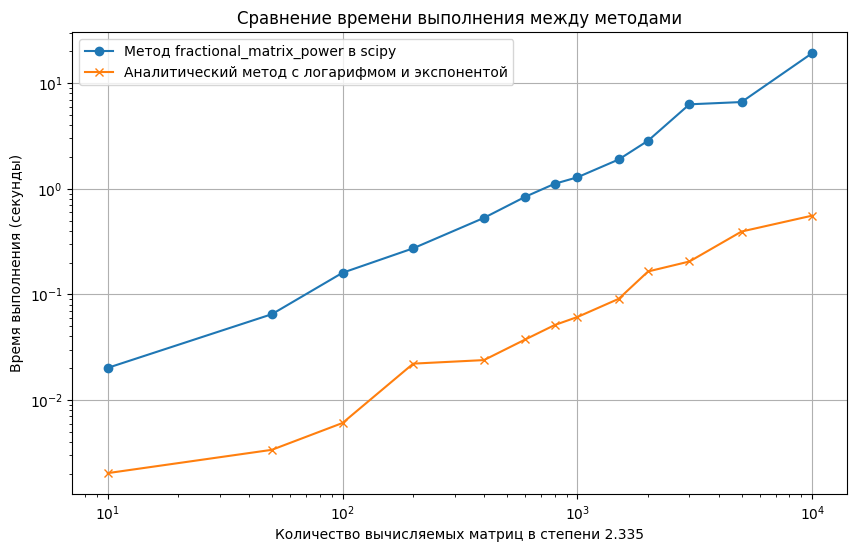

Количество степеней: 10, Время выполнения (scipy): 0.020185 секунд, Время выполнения (R): 0.002036 секунд
Количество степеней: 50, Время выполнения (scipy): 0.065007 секунд, Время выполнения (R): 0.003383 секунд
Количество степеней: 100, Время выполнения (scipy): 0.160397 секунд, Время выполнения (R): 0.006072 секунд
Количество степеней: 200, Время выполнения (scipy): 0.273395 секунд, Время выполнения (R): 0.022139 секунд
Количество степеней: 400, Время выполнения (scipy): 0.530483 секунд, Время выполнения (R): 0.023913 секунд
Количество степеней: 600, Время выполнения (scipy): 0.840635 секунд, Время выполнения (R): 0.037496 секунд
Количество степеней: 800, Время выполнения (scipy): 1.115438 секунд, Время выполнения (R): 0.051315 секунд
Количество степеней: 1000, Время выполнения (scipy): 1.284616 секунд, Время выполнения (R): 0.061140 секунд
Количество степеней: 1500, Время выполнения (scipy): 1.894949 секунд, Время выполнения (R): 0.090932 секунд
Количество степеней: 2000, Время выпо

In [10]:
A = np.array([[1, 2], [3, 4]])

q = 2.335

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000] #50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
      fractional_matrix_power(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        B = matrix_log_analytic(A)
        matrix_exp_analytic(B, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Метод fractional_matrix_power в scipy')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод с логарифмом и экспонентой')
plt.xlabel('Количество вычисляемых матриц в степени 2.335')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

<ipython-input-179-9e2a1917ca48>:10: RuntimeWarning: invalid value encountered in scalar power
  q1, q2 = (u + r)**n, (u - r)**n
<ipython-input-179-9e2a1917ca48>:21: RuntimeWarning: invalid value encountered in scalar power
  p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5
<ipython-input-249-c801f2e6c9e4>:14: RuntimeWarning: invalid value encountered in log
  s = np.log((u+r)/(u-r))
<ipython-input-249-c801f2e6c9e4>:15: RuntimeWarning: invalid value encountered in log
  p1 = np.log(det_A)


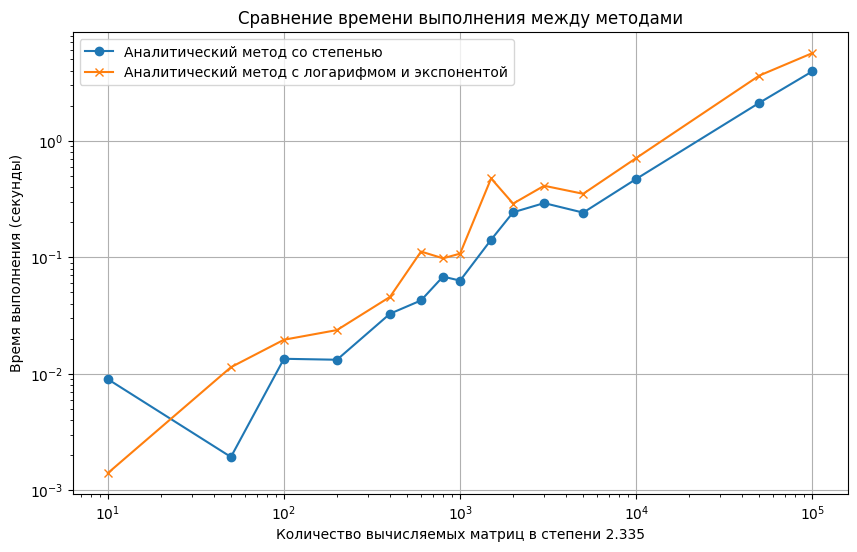

Количество степеней: 10, Время выполнения (scipy): 0.008980 секунд, Время выполнения (R): 0.001401 секунд
Количество степеней: 50, Время выполнения (scipy): 0.001928 секунд, Время выполнения (R): 0.011375 секунд
Количество степеней: 100, Время выполнения (scipy): 0.013432 секунд, Время выполнения (R): 0.019575 секунд
Количество степеней: 200, Время выполнения (scipy): 0.013180 секунд, Время выполнения (R): 0.023697 секунд
Количество степеней: 400, Время выполнения (scipy): 0.032736 секунд, Время выполнения (R): 0.045662 секунд
Количество степеней: 600, Время выполнения (scipy): 0.042581 секунд, Время выполнения (R): 0.111909 секунд
Количество степеней: 800, Время выполнения (scipy): 0.068209 секунд, Время выполнения (R): 0.097876 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.062976 секунд, Время выполнения (R): 0.107385 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.141308 секунд, Время выполнения (R): 0.474971 секунд
Количество степеней: 2000, Время выпо

In [256]:
A = np.array([[1, 2], [3, 4]])

q = 2.335

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
       matrix_power_analytic(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        B = matrix_log_analytic(A)
        matrix_exp_analytic(B, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Аналитический метод со степенью')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод с логарифмом и экспонентой')
plt.xlabel('Количество вычисляемых матриц в степени 2.335')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

<ipython-input-5-9e2a1917ca48>:10: RuntimeWarning: invalid value encountered in scalar power
  q1, q2 = (u + r)**n, (u - r)**n
<ipython-input-5-9e2a1917ca48>:21: RuntimeWarning: invalid value encountered in scalar power
  p2 = (r**(n-1))*((1+t)**n - (t-1)**n)*0.5
<ipython-input-4-13509f57cf37>:14: RuntimeWarning: invalid value encountered in log
  s = np.log((u+r)/(u-r))
<ipython-input-4-13509f57cf37>:15: RuntimeWarning: invalid value encountered in log
  p1 = np.log(det_A)


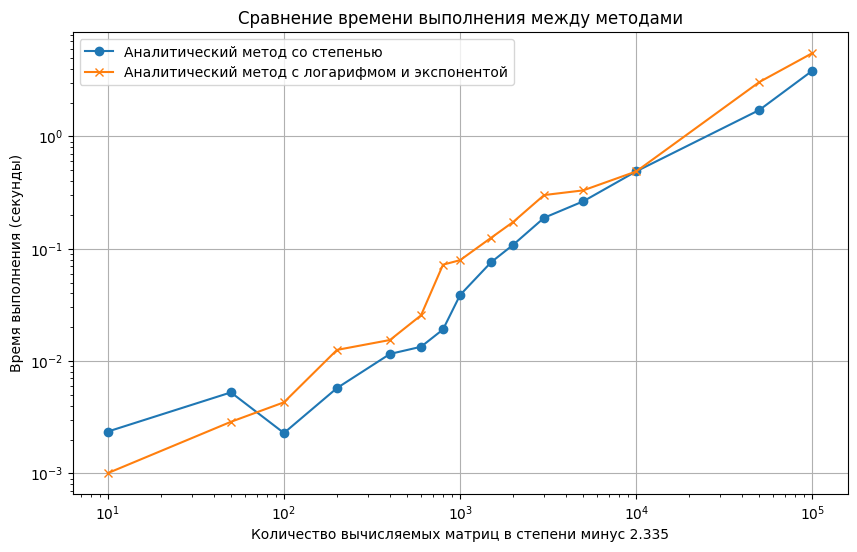

Количество степеней: 10, Время выполнения (scipy): 0.002358 секунд, Время выполнения (R): 0.001006 секунд
Количество степеней: 50, Время выполнения (scipy): 0.005264 секунд, Время выполнения (R): 0.002881 секунд
Количество степеней: 100, Время выполнения (scipy): 0.002289 секунд, Время выполнения (R): 0.004295 секунд
Количество степеней: 200, Время выполнения (scipy): 0.005752 секунд, Время выполнения (R): 0.012576 секунд
Количество степеней: 400, Время выполнения (scipy): 0.011579 секунд, Время выполнения (R): 0.015408 секунд
Количество степеней: 600, Время выполнения (scipy): 0.013408 секунд, Время выполнения (R): 0.025548 секунд
Количество степеней: 800, Время выполнения (scipy): 0.019123 секунд, Время выполнения (R): 0.072140 секунд
Количество степеней: 1000, Время выполнения (scipy): 0.038724 секунд, Время выполнения (R): 0.079129 секунд
Количество степеней: 1500, Время выполнения (scipy): 0.075830 секунд, Время выполнения (R): 0.125210 секунд
Количество степеней: 2000, Время выпо

In [9]:
A = np.array([[1, 2], [3, 4]])

q = -2.335

num_power = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000, 50000, 100000]
execution_times = []
execution_times_R = []

for n in num_power:

    start_time = time.time()
    for k in range(n):
       matrix_power_analytic(A, q)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        B = matrix_log_analytic(A)
        matrix_exp_analytic(B, q)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

plt.figure(figsize=(10, 6))
plt.plot(num_power, execution_times, marker='o', label='Аналитический метод со степенью')
plt.plot(num_power, execution_times_R, marker='x', label='Аналитический метод с логарифмом и экспонентой')
plt.xlabel('Количество вычисляемых матриц в степени минус 2.335')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R in zip(num_power, execution_times, execution_times_R):
    print(f"Количество степеней: {n}, Время выполнения (scipy): {t_scipy:.6f} секунд, Время выполнения (R): {t_R:.6f} секунд")

##### Сравнение методов вычисления квадратных корней.

Воспользуемся теоремой Гамильтона-Кэли и запишем

$$
A = \tau \sqrt{A} - \delta I
$$

где $\tau$ — это след матрицы $\sqrt{A}$, а $\delta$ — определитель матрицы $\sqrt{A}$. Предположим, что матрица $A$ имеет след $T$ и определитель $\Delta$ и не является кратной матрице $I$. Тогда

$$
\sqrt{A} = \frac{1}{\tau}(A + \delta I)
$$

Кроме того, $\delta^2 = \Delta$ или $\delta = \pm \sqrt{\Delta}$. Используя эти формулы, получаем

$$
T A - \Delta I = A^2 = (\tau \sqrt{A} - \delta I)^2 = \tau^2 A - 2 \tau \delta \sqrt{A} + \delta^2 I = \left(\tau^2 - 2 \delta\right) A - \Delta I
$$

Таким образом, $T = \tau^2 - 2 \delta$. Следовательно, $\tau = \pm \sqrt{T + 2 \delta}$ и, наконец,

$$
\sqrt{A} = \frac{\pm 1}{\sqrt{T + 2 \delta}}(A + \delta I), \quad \delta = \pm \sqrt{\Delta}
$$

В более общепринятых обозначениях

$$
\sqrt{A}=\frac{\pm 1}{\sqrt{\operatorname{tr}(A)+2 \sqrt{\operatorname{det} A}}}(A\pm I \sqrt{\operatorname{det} A})
$$

Вспомним формулу, уже выведенную ранее

$$
\begin{aligned}
&f(A)=\frac{f\left(\lambda_{+}\right)+f\left(\lambda_{-}\right)}{2} I+\frac{A-\left(\frac{\operatorname{tr}(A)}{2}\right) I}{\sqrt{\left(\frac{\operatorname{tr}(A)}{2}\right)^2-|A|}} \frac{f\left(\lambda_{+}\right)-f\left(\lambda_{-}\right)}{2}\\
&\text { где } f(x)=\sqrt{x}
\end{aligned}
$$

Введем обозначения, что мы уже использовали

$$
u = \frac{tr(A)}{2};  r = \sqrt{(u^2 - det(A))}; \lambda_{\pm} = u \pm r
$$

В них формула запишется следующим образом

$$
\sqrt A =\frac{\sqrt{u+r}+\sqrt{u-r}}{2} I+\frac{\sqrt{u+r}-\sqrt{u-r}}{2 r}\left(A - u\cdot I\right)
$$

А новое аналитическое выражение

$$
\sqrt{A}=\frac{\pm 1}{\sqrt{2 u+2 \sqrt{u^2 - r^2}}}(A\pm I \sqrt{u^2 - r^2})
$$

Новое выражение гораздо лучше для практического применения, так как оно не содержит устранимых особенностей и требует использования меньшего количества вычислений. Кроме того, его лучше использовать в форме, в которой оно выражено через след и определитель. Знаки везде берем положительные, если в качестве корня мы хотим получить матрицу с положительным определителем, и отрицательные - если с отрицательным.


In [15]:
def matrix_sqrt_analytic(A, signum = 1):

    a, b, c, d = A.flatten()
    # Вычисляем след и определитель матрицы
    trace_A = a + d
    det_A = a*d - b*c
    p = (det_A)**0.5

    # Вычисляем матрицу I
    I = np.eye(A.shape[0])

    result = (signum*I*p + A)/((trace_A + signum*2*p)**0.5)
    return result

A = np.array([[1, 2], [3, 4]])


print(matrix_sqrt_analytic(A @ A, -1) )

[[1. 2.]
 [3. 4.]]


Задачу вычисления квадратного корня из матрицы можно также рассматривать как задачу решения матричного уравнения:

$$
X = A^{0.5}
$$

Можно решить его, используя метод Ньютона:

$$
\  X_0=I_n;\  X_{n+1}=\frac{1}{2}\left(X_n+A X_n^{-1}\right) .
$$

In [23]:
def matrix_sqrt_newton(A, tol=1e-9, max_iter=1000, epsilon=1e-10):
    try:
        inv_A = np.linalg.inv(A)


    except np.linalg.LinAlgError:

        return None
    X = np.eye(A.shape[0])
    iter_count = 0

    while iter_count < max_iter:
        # Если X близка к сингулярной, добавляем небольшое значение на диагональ
        if np.linalg.cond(X) > 1 / epsilon:
            X += np.eye(A.shape[0]) * epsilon

        X_next = 0.5 * (X + A @ np.linalg.inv(X))

        # Проверка относительной погрешности по спектральной норме
        if np.linalg.norm(X_next - X, ord=2) / np.linalg.norm(X_next, ord=2) < tol:
            break

        X = X_next
        iter_count += 1

    return X, iter_count

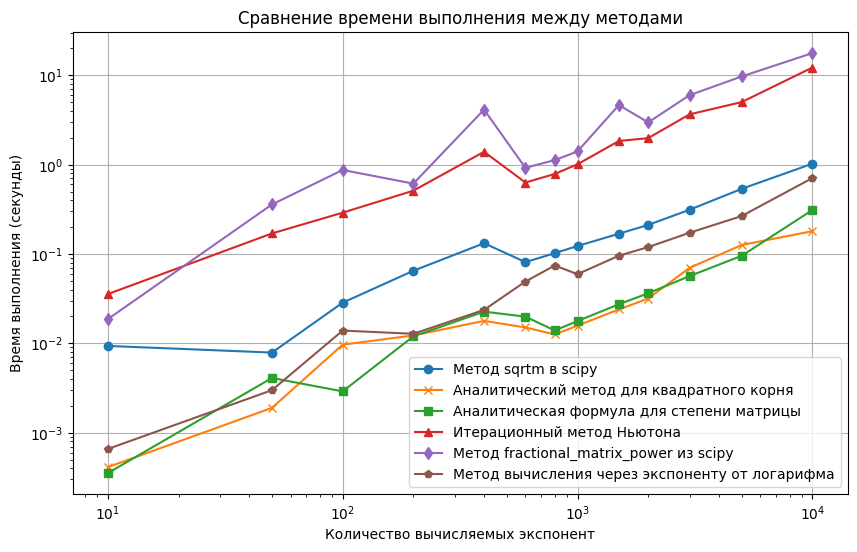

Количество корней: 10, Метод sqrtm в scipy: 0.009366 секунд, Аналитический метод для квадратного корня: 0.000412 секунд, Аналитическая формула для степени матрицы: 0.000353 секунд, Итерационный метод Ньютона: 0.035605 секунд, Метод fractional_matrix_power из scipy: 0.018677 секунд, Метод вычисления через экспоненту от логарифма: 0.000658 секунд
Количество корней: 50, Метод sqrtm в scipy: 0.007891 секунд, Аналитический метод для квадратного корня: 0.001898 секунд, Аналитическая формула для степени матрицы: 0.004102 секунд, Итерационный метод Ньютона: 0.169925 секунд, Метод fractional_matrix_power из scipy: 0.358244 секунд, Метод вычисления через экспоненту от логарифма: 0.002995 секунд
Количество корней: 100, Метод sqrtm в scipy: 0.028524 секунд, Аналитический метод для квадратного корня: 0.009671 секунд, Аналитическая формула для степени матрицы: 0.002903 секунд, Итерационный метод Ньютона: 0.290011 секунд, Метод fractional_matrix_power из scipy: 0.871742 секунд, Метод вычисления через

In [29]:
A = np.array([[5, 2], [3, 4]])

num_sroots = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 5000, 10000] # 50000, 100000]
execution_times = []
execution_times_R = []
execution_times_R1 = []
execution_times_R2 = []
execution_times_R3 = []
execution_times_R4 = []

for n in num_sroots:

    start_time = time.time()
    for k in range(n):
      sqrtm(A)
    end_time = time.time()

    execution_times.append(end_time - start_time)

    # Временные замеры для метода R (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R
        matrix_sqrt_analytic(A)
    end_time = time.time()
    execution_times_R.append(end_time - start_time)

    # Временные замеры для метода R1 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R1
        matrix_power_analytic(A, 0.5)
    end_time = time.time()
    execution_times_R1.append(end_time - start_time)

    # Временные замеры для метода R2 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R2
        matrix_sqrt_newton(A)
    end_time = time.time()
    execution_times_R2.append(end_time - start_time)

    # Временные замеры для метода R3 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R3
        fractional_matrix_power(A, 0.5)
    end_time = time.time()
    execution_times_R3.append(end_time - start_time)

    # Временные замеры для метода R4 (замените на Ваш метод)
    start_time = time.time()
    for k in range(n):
        # Здесь должен быть Ваш метод R4
        B = matrix_log_analytic(A)
        matrix_exp_analytic(B, 0.5)
    end_time = time.time()
    execution_times_R4.append(end_time - start_time)


plt.figure(figsize=(10, 6))
plt.plot(num_sroots, execution_times, marker='o', label='Метод sqrtm в scipy')
plt.plot(num_sroots, execution_times_R, marker='x', label='Аналитический метод для квадратного корня')
plt.plot(num_sroots, execution_times_R1, marker='s', label='Аналитическая формула для степени матрицы')
plt.plot(num_sroots, execution_times_R2, marker='^', label='Итерационный метод Ньютона')
plt.plot(num_sroots, execution_times_R3, marker='d', label='Метод fractional_matrix_power из scipy')
plt.plot(num_sroots, execution_times_R4, marker='p', label='Метод вычисления через экспоненту от логарифма')
plt.xlabel('Количество вычисляемых экспонент')
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение времени выполнения между методами')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Вывод результатов
for n, t_scipy, t_R, t_R1, t_R2, t_R3, t_R4 in zip(num_sroots, execution_times, execution_times_R, execution_times_R1, execution_times_R2, execution_times_R3, execution_times_R4):
    print(f"Количество корней: {n}, Метод sqrtm в scipy: {t_scipy:.6f} секунд, "
          f"Аналитический метод для квадратного корня: {t_R:.6f} секунд, "
          f"Аналитическая формула для степени матрицы: {t_R1:.6f} секунд, "
          f"Итерационный метод Ньютона: {t_R2:.6f} секунд, "
          f"Метод fractional_matrix_power из scipy: {t_R3:.6f} секунд, "
          f"Метод вычисления через экспоненту от логарифма: {t_R4:.6f} секунд")

## Матрицы размера $3 \times 3$.

### Виды матриц $3 \times 3$ и их практические применения.

### Реализация алгоритмов и сравнение их работы.

## Общие выводы.

## Список литературы.

### **Статья про метод масштабирования и использования аппроксимации Паде**

Awad H. Al-Mohy and Nicholas J. Higham, (2009), "A New Scaling
and Squaring Algorithm for the Matrix Exponential", SIAM J. Matrix
Anal. Appl. 31(3):970-989, :doi:`10.1137/09074721X`

Этот метод используется встроенная реализация в scipy и в множестве других библиотек.
Порядок аппроксимации переменный, определяется в зависимости от матрицы.

### **Статья про метод вычисления степеней матрицы с помощью гибридных чисел**

Finding n-th Roots of a real Matrix using Hybrid Numbers July 2018
Conference: 2018 Alterman Conference and School on Geometric Algebra and Kahler Calculus At: Milan / Italy Mustafa Özdemir Akdeniz University

**Аннотация.**

In this presentation, some of the basic methods to find n-th roots of a 2x2 matrix are given. Also, we give a new method for finding n-th roots of a 2 × 2 real matrix with the help of hybrid numbers.


### **Статья про гибридные числа**

Geometry of Generalized Complex Numbers Anthony A. Harkin &Joseph B. Harkin Mathematics Magazine, Volume 77, 2004 - Issue 2, Pages 118-129

 Published online: 16 Apr 2018

 **Аннотация.**

 It may come as a surprise to some that there are useful definitions of the imaginary unit i besides i 2 =-1. The alternative definitions i 2 =1 and i 2 =0 give rise to complex number systems first studied by W. Clifford and E. Study. What are the properties of these complex number systems? The geometries of the complex planes corresponding to these modified definitions of the imaginary unit turn out to be related to the geometries of Minkowski and Laguerre.


###**Статья про аппроксимации Паде**

Burtsev Y. High Precision Methods Based on Pade Approximation of Matrix Exponent for Numerical Analysis of Stiff-Oscillatory Electrical Circuits. Proceedings - 2020 International Conference on Industrial Engineering, Applications and Manufacturing, ICIEAM 2020; IEEE inc.

**Более свежая версия.**

Ю.А. Бурцев "Решение задачи Коши высокоточными методами на основе аппроксимации Паде матричной экспоненты". Труды Института системного анализа Российской академии наук (ИСА РАН). 2024.  Стр. 3-12.

**Аннотация.**

Предложено семейство новых численных методов для решения систем линейных обыкновенных дифференциальных уравнений. Методы основаны на разложении аппроксимации Паде матричной экспоненты на простейшие дроби. Новые методы по точности и устойчивости эквивалентны некоторым неявным методам типа Рунге-Кутты, однако намного проще в
реализации и в несколько раз более экономичны по вычислениям.



### Статьи про библиотечный метод вычисления матричного логарифма и дробной степени

**Первая статья.**

Nicholas J. Higham and Lijing lin (2011)
"A Schur-Pade Algorithm for Fractional Powers of a Matrix."
IAM Journal on Matrix Analysis and Applications,
32 (3). pp. 1056-1078. ISSN 0895-4798

**Аннотация.**


A new algorithm is developed for computing arbitrary real powers $A^p$ of a matrix $A \in \mathbb{C}^{n \times n}$. The algorithm starts with a Schur decomposition, takes $k$ square roots of the triangular factor $T$, evaluates an $\left[m / m\right.$ ] Padé approximant of $(1-x)^p$ at $I-T^{1 / 2^k}$, and squares the result $k$ times. The parameters $k$ and $m$ are chosen to minimize the cost subject to achieving double precision accuracy in the evaluation of the Pade approximant, making use of a result that bounds the error in the matrix Padé approximant by the error in the scalar Padé approximant with argument the norm of the matrix. The Padé approximant is evaluated from the continued fraction representation in bottom-up fashion, which is shown to be numerically stable. In the squaring phase the diagonal and first superdiagonal are computed from explicit formulae for $T^{p / 2^j}$, yielding increased accuracy. Since the basic algorithm is designed for $p \in(-1,1)$, a criterion for reducing an arbitrary real $p$ to this range is developed, making use of bounds for the condition number of the $A^p$ problem. How best to compute $A^k$ for a negative integer $k$ is also investigated. In numerical experiments the new algorithm is found to be superior in accuracy and stability to several alternatives, including the use of an eigendecomposition and approaches based on the formula $A^p=\exp (p \log (A))$.


**Вторая статья.**

Nicholas J. Higham and Lijing lin (2013)
"An improved Schur-Pade Algorithm for Fractional Powers of a Matrix and their frechet derivatives."

IAM Journal on Matrix Analysis and Applications,
Vol. 34, No. 3, pp. 1341–1360

**Аннотация.**

Abstract. The Schur-Padé algorithm [N. J. Higham and L. Lin, SIAM J. Matriz Anal. Appl., 32 (2011), pp. 1056-1078] computes arbitrary real powers $A^t$ of a matrix $A \in \mathbb{C}^{n \times n}$ using the building blocks of Schur decomposition, matrix square roots, and Padé approximants. We improve the algorithm by basing the underlying error analysis on the quantities $\left\|(I-A)^k\right\|^{1 / k}$, for several small $k$, instead of $\|I-A\|$. We extend the algorithm so that it computes along with $A^t$ one or more Fréchet derivatives, with reuse of information when more than one Fréchet derivative is required, as is the case in condition number estimation. We also derive a version of the extended algorithm that works entirely in real arithmetic when the data is real. Our numerical experiments show the new algorithms to be superior in accuracy to, and often faster than, the original Schur-Pade algorithm for computing matrix powers and more accurate than several alternative methods for computing the Fréchet derivative. They also show that reliable estimates of the condition number of $A^t$ are obtained by combining the algorithms with a matrix norm estimator.

**Третья статья.**
MULTIPRECISION ALGORITHMS FOR COMPUTING THE
MATRIX LOGARITHM

Nicholas J. Higham and Massimiliano Fasiy (2018)
"Multiprecision Algorithms for computing the Matrix Logarithm."

IAM Journal on Matrix Analysis and Applications,
Vol. 39, No. 1, pp. 472-491

**Аннотация.**

Abstract. Two algorithms are developed for computing the matrix logarithm in floating point arithmetic of any specified precision. The backward error-based approach used in the state of the art inverse scaling and squaring algorithms does not conveniently extend to a multiprecision environment, so instead we choose algorithmic parameters based on a forward error bound. We derive a new forward error bound for Padé approximants that for highly nonnormal matrices can be much smaller than the classical bound of Kenney and Laub. One of our algorithms exploits a Schur decomposition while the other is transformation-free and uses only the computational kernels of matrix multiplication and the solution of multiple right-hand side linear systems. For double precision computations the algorithms are competitive with the state of the art algorithm of Al-Mohy, Higham, and Relton implemented in logm in MATLAB. They are intended for computing environments providing multiprecision floating point arithmetic, such as Julia, MATLAB via the Symbolic Math Toolbox or the Multiprecision Computing Toolbox, or Python with the mpmath or SymPy package. We show experimentally that the algorithms behave in a forward stable manner ower a wide range of precisions, unlike existing alternatives.

###Статья про сравнение 5 методов вычисления матричных квадратных корней.


Northshield, S. (2010). Square Roots of 2x2 Matrices.
Contemporary Mathematics, 517

**Аннотация.**

This paper is designed to pique the interest of undergraduate students who are familiar with the concepts of linear algebra. We investigate five methods of computing square roots of two-by-two matrices. Each method gives rise to applications and examples. Topics touched upon include solutions to Abel's functional equation, Fibonacci numbers, Mobius transformations, systems of differential equations, Newton's method applied to matrices (including surprising pictures and open questions), continued fraction representations of matrices, quadratic number fields, and quadratic forms.

### Статья, где был введен встроенный в scipy алгоритм вычисления квадратного корня из матрицы

Edvin Deadman, Nicholas J. Higham, Rui Ralha (2013) “Blocked Schur Algorithms for Computing the Matrix Square Root, Lecture Notes in Computer Science, 7782. pp. 171-182.

https://github.com/JuliaLang/LinearAlgebra.jl/issues/829

The Schur method for computing a matrix square root reduces the matrix to the Schur triangular form and then computes a square root of the triangular matrix. We show that by using either standard blocking or recursive blocking the computation of the square root of the triangular matrix can be made rich in matrix multiplication. Numerical experiments making appropriate use of level 3 BLAS show significant speedups over the point algorithm, both in the square root phase and in the algorithm as a whole. In parallel implementations, recursive blocking is found to provide better performance than standard blocking when the parallelism comes only from threaded BLAS, but the reverse is true when parallelism is explicitly expressed using OpenMP. The excellent numerical stability of the point algorithm is shown to be preserved by blocking. These results are extended to the real Schur method. Blocking is also shown to be effective for multiplying triangular matrices.

